# **Improving Time Series Upsampling using ML Methods**

# Model Selection
Edit `model_id` to select which model to run.

0: LSTM Seq2Seq

1: LSTM Seq2Seq with Attention

2: 4 Layer 1d CNN with Residual Connection

3: 4 Layer 1d CNN without Residual Connection

4: 4 Layer 1d CNN with Residual Connection and Dilation

5: 1d UNet

In [52]:
model_id = 3

# Upsampling Factor Selection

Edit `up_factor` to select the upsampling factor of the method (`2`, `4` or `8`).

In [53]:
up_factor = 4

# Libraries

In [54]:
try:
    from dtaidistance import dtw
except ImportError:
    !pip install dtaidistance
    from dtaidistance import dtw

In [55]:
!pip install torchvista

In [56]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
from scipy.interpolate import interp1d

from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import tqdm  # For Progress Bar

from torchvista import trace_model

Setting Seed for Reproducibility

In [57]:
seed = 5965

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dataset Import & Preparation

Individual Household Electric Power Consumption Dataset Available at: https://doi.org/10.24432/C58K54

Info:
1. date: Date in format dd/mm/yyyy

2. time: time in format hh:mm:ss

3. global_active_power: household global minute-averaged active power (in kilowatt)

4. global_reactive_power: household global minute-averaged reactive power (in kVAR)

5. voltage: minute-averaged voltage (in volt)

6. global_intensity: household global minute-averaged current intensity (in ampere)

7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [58]:
# Load TXT file of the dataset
df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/household_power_consumption.txt', sep=';')
# df = pd.read_csv('/content/household_power_consumption.txt', sep=';')

# Combine 'Date' and 'Time' into one column and convert dataframe into datetime object
df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Delete 'Time' column
df.drop(columns=['Time'], inplace=True)

# Convert all number values to type float64
for col in df.columns[1:7]:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Invalid values become NaN

# Set date as index
df.set_index('Date', inplace=True)

/tmp/ipython-input-2093196512.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/household_power_consumption.txt', sep=';')


Converting Power to Energy (Kilowatt-hours)

In [59]:
df['Global_energy_kwh'] = df['Global_active_power'] * (1 / 60)

Handling Missing Values

In [60]:
# Missing values per column
print("Missing Values per Column:\n", df.isnull().sum())

# Mask
missing_mask = df['Global_energy_kwh'].isnull()

# Number Of Missing Values
num_missing = missing_mask.sum()
print("\nTotal missing values in Global_energy_kwh column:", num_missing)

# Percentage of Missing Values
total_values = df['Global_energy_kwh'].shape[0]
missing_percentage = (num_missing / total_values) * 100
print(f"Percentage of missing values in Global_energy_kwh: {missing_percentage:.2f}%")

# Timestamps where values are missing
missing_timestamps = df[missing_mask].index
print("\nMissing values occur at:", missing_timestamps)

# Linear Interpolation to fill all the missing values
df['Energy_filled'] = df['Global_energy_kwh'].interpolate(method='linear')

print("\nTotal missing values in Global_energy column after interpolation:", df['Energy_filled'].isnull().sum())

Missing Values per Column:
 Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Global_energy_kwh        25979
dtype: int64

Total missing values in Global_energy_kwh column: 25979
Percentage of missing values in Global_energy_kwh: 1.25%

Missing values occur at: DatetimeIndex(['2006-12-21 11:23:00', '2006-12-21 11:24:00',
               '2006-12-30 10:08:00', '2006-12-30 10:09:00',
               '2007-01-14 18:36:00', '2007-01-28 17:13:00',
               '2007-02-22 22:58:00', '2007-02-22 22:59:00',
               '2007-03-25 17:52:00', '2007-04-28 00:21:00',
               ...
               '2010-09-28 19:04:00', '2010-09-28 19:05:00',
               '2010-09-28 19:06:00', '2010-09-28 19:07:00',
               '2010-09-28 19:08:00', '2010-09-28 19:09:00',
               '2010-09-28 19:10:00', '2010-09-28 19:11:00',
   

Useful Plots

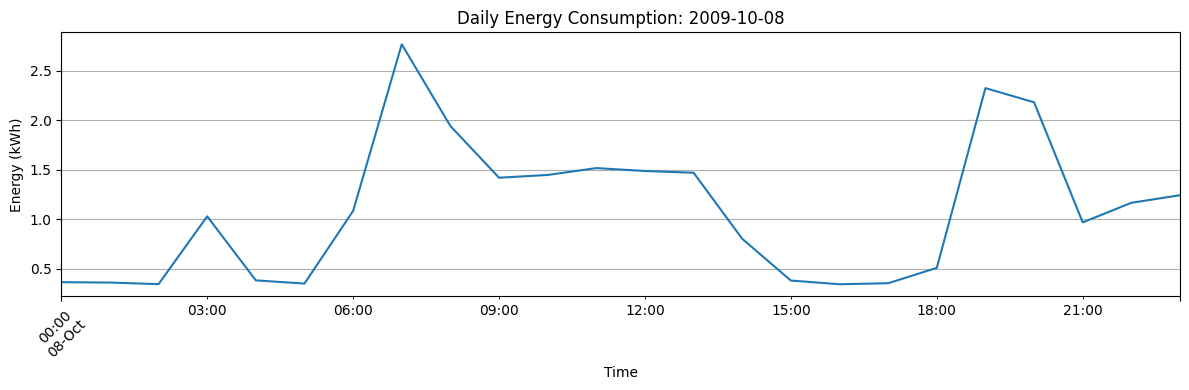

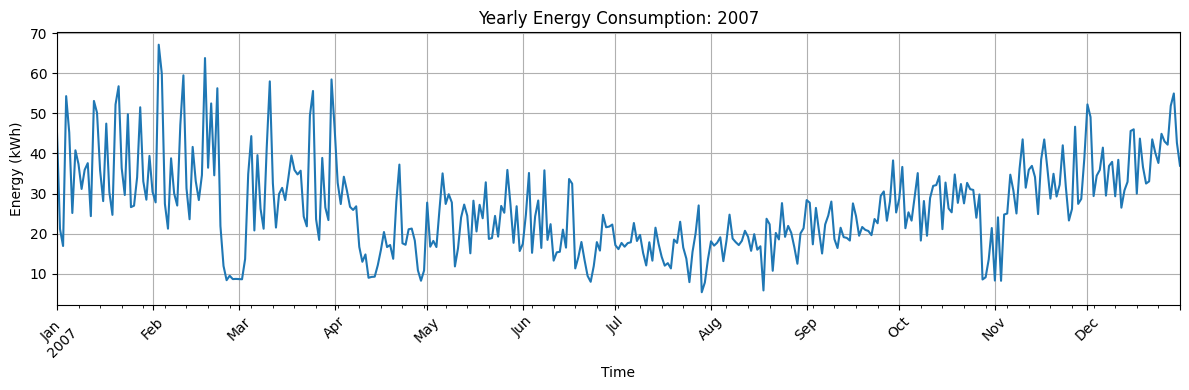

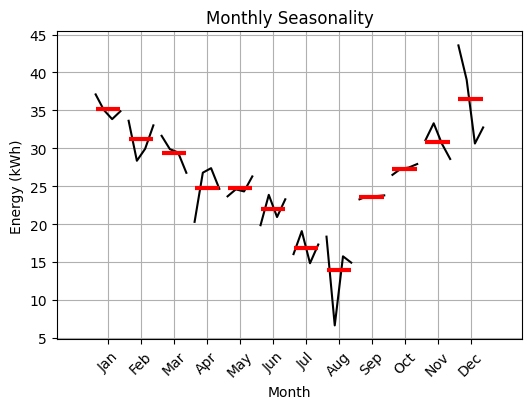

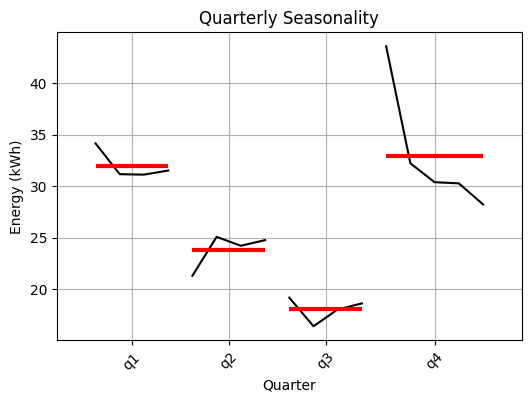

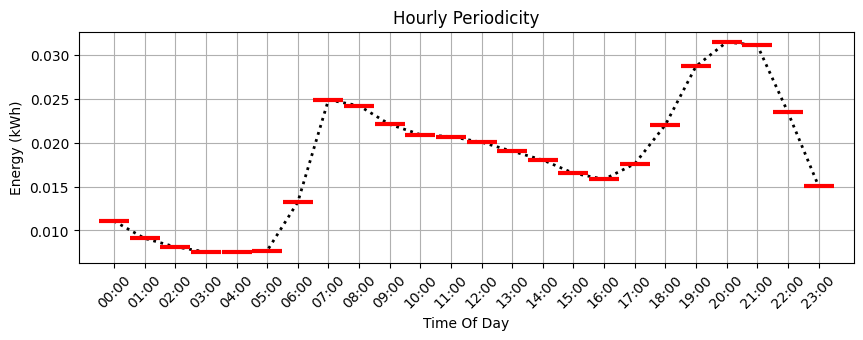

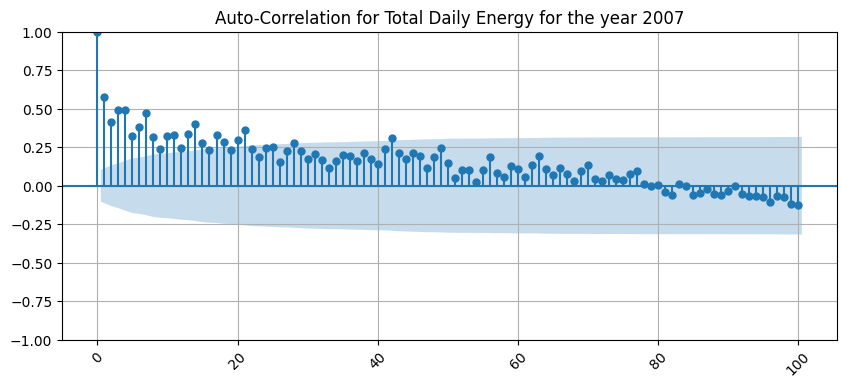

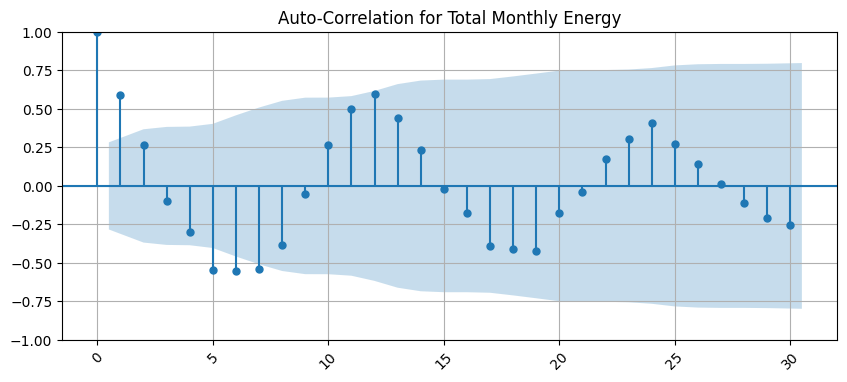

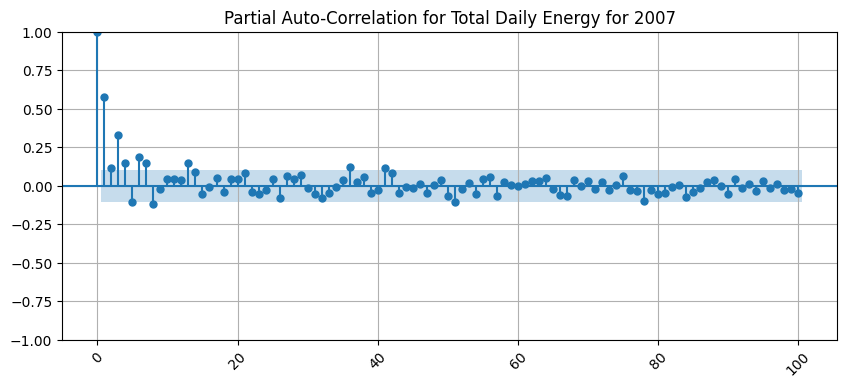

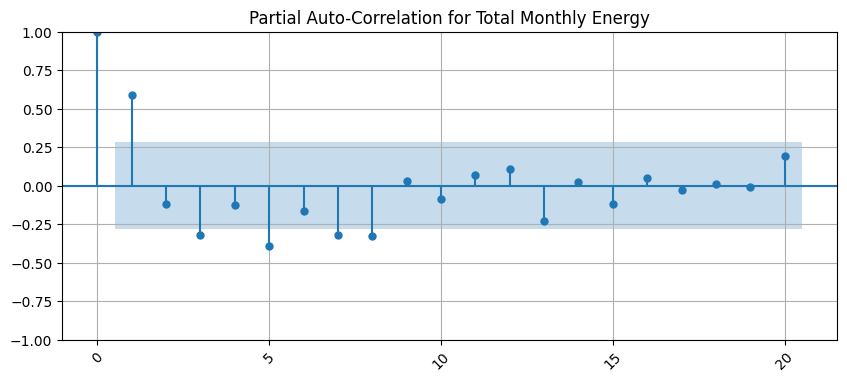

In [61]:
# Resample hourly - The value that represents each hour is the total energy consumed in that hour
total_hourly_energy = df['Energy_filled'].resample('h').sum()

# Resample daily - The value that represents each day is the total energy consumed in that day
total_daily_energy = df['Energy_filled'].resample('D').sum()

# Plot specific day
day_to_plot = '2009-10-08'

plt.figure(figsize=(12, 4))
total_hourly_energy[day_to_plot:day_to_plot].plot()
plt.title(f'Daily Energy Consumption: {day_to_plot}')
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Specific Year
year_to_plot = '2007'

plt.figure(figsize=(12, 4))
total_daily_energy[year_to_plot:year_to_plot].plot()
plt.title(f'Yearly Energy Consumption: {year_to_plot}')
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# SEASONALITY
# Plotting Monthly Seasonality
plt.figure(figsize=(6, 4))
month_plot(total_daily_energy.resample('ME').mean(), ax=plt.gca())
plt.title('Monthly Seasonality')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plotting Quarterly Seasonality
plt.figure(figsize=(6, 4))
quarter_plot(total_daily_energy.resample('QE').mean(), ax=plt.gca())
plt.title('Quarterly Seasonality')
plt.xlabel('Quarter')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plotting Hourly Periodicity
df['hour'] = df.index.hour
avg_daily = df.groupby('hour')['Energy_filled'].mean()
plt.figure(figsize=(10, 3))
plt.plot(avg_daily.index, avg_daily.values, marker='_', markersize = 22, markeredgewidth=3, linestyle=':', linewidth=2, color='black', markeredgecolor='red')
plt.title('Hourly Periodicity')
plt.xlabel('Time Of Day')
plt.ylabel('Energy (kWh)')
hour_labels = [f"{h:02d}:00" for h in range(24)]  # 0:00 -> 24:00
plt.xticks(range(0, 24), hour_labels)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot Autocorrelation (ACF) for daily max power
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(total_daily_energy[year_to_plot:year_to_plot], lags=100, ax=ax)
plt.title(f'Auto-Correlation for Total Daily Energy for the year {year_to_plot}')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(total_daily_energy.resample('ME').sum(), lags=30, ax=ax)
plt.title(f'Auto-Correlation for Total Monthly Energy')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot Partial Autocorrelation (PACF) for daily max power
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(total_daily_energy[year_to_plot:year_to_plot], lags=100, ax=ax)
plt.title(f'Partial Auto-Correlation for Total Daily Energy for {year_to_plot}')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(total_daily_energy.resample('ME').sum(), lags=20, ax=ax)
plt.title(f'Partial Auto-Correlation for Total Monthly Energy')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

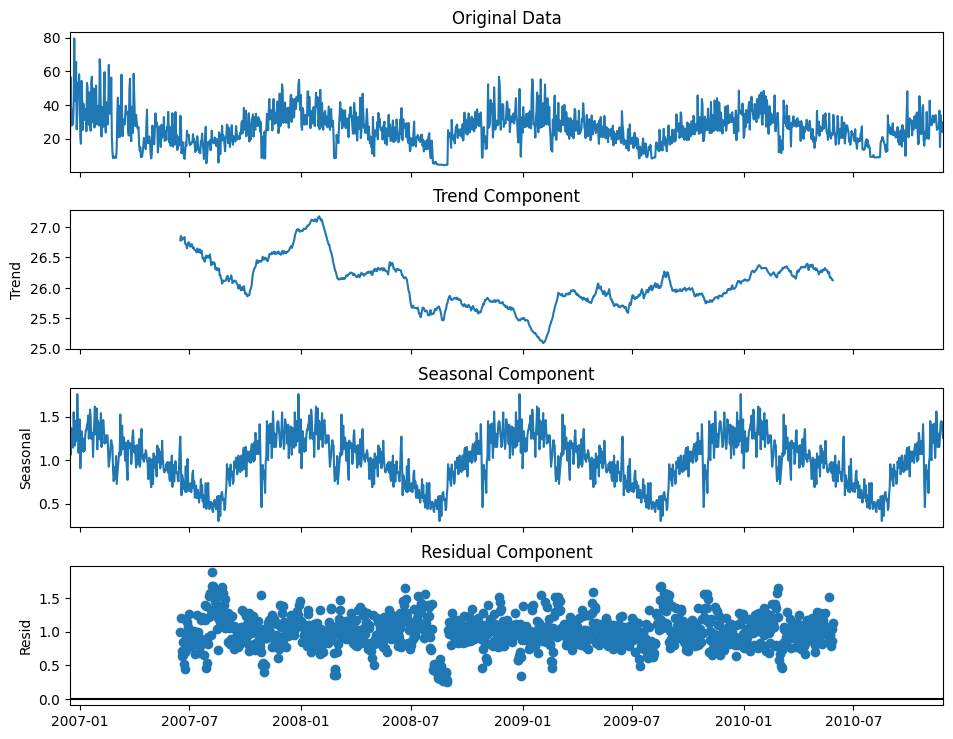

In [62]:
# Seasonal Decomposition
decomposition = seasonal_decompose(total_daily_energy, model='mul', period=365)
fig = decomposition.plot()
fig.set_size_inches(10, 8)
axes = fig.axes
axes[0].set_title('Original Data')
axes[1].set_title('Trend Component')
axes[2].set_title('Seasonal Component')
axes[3].set_title('Residual Component')
plt.show()

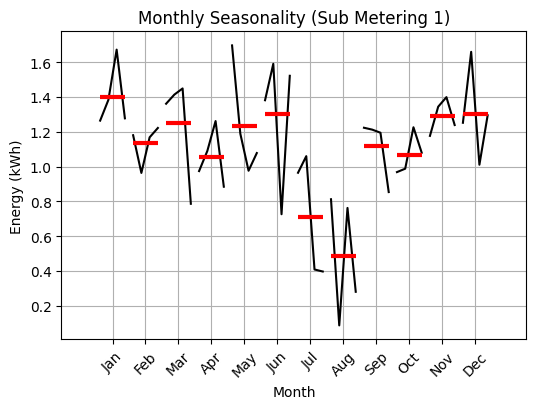

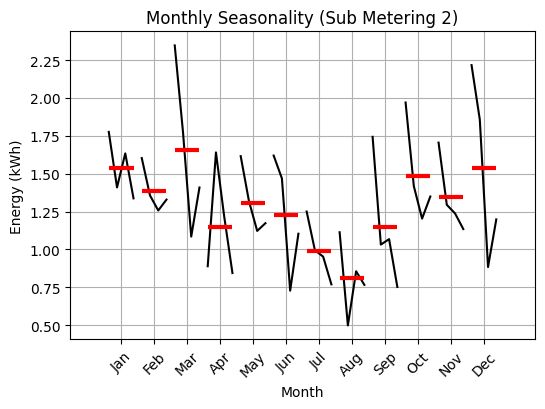

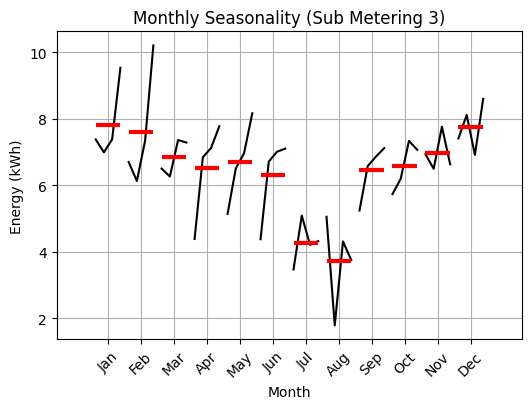

In [63]:
# SUB METERING SEASONALITY
# Linear Interpolation to fill all the missing values
df['metering1_fill'] = df['Sub_metering_1'].interpolate(method='linear')
df['metering2_fill'] = df['Sub_metering_2'].interpolate(method='linear')
df['metering3_fill'] = df['Sub_metering_3'].interpolate(method='linear')

# Plotting Monthly Seasonality
plt.figure(figsize=(6, 4))
month_plot(df['metering1_fill'].resample('ME').mean(), ax=plt.gca())
plt.title('Monthly Seasonality (Sub Metering 1)')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6, 4))
month_plot(df['metering2_fill'].resample('ME').mean(), ax=plt.gca())
plt.title('Monthly Seasonality (Sub Metering 2)')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6, 4))
month_plot(df['metering3_fill'].resample('ME').mean(), ax=plt.gca())
plt.title('Monthly Seasonality (Sub Metering 3)')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

**Importing Additional Datasets**

CU-BEMS, Smart Building Energy and IAQ Dataset Available at https://www.kaggle.com/datasets/claytonmiller/cubems-smart-building-energy-and-iaq-data:

Floor 1 info:

1. Date: Date in format "yyyy/mm/dd hh:mm:ss"

2. z1_Light(kW): Zone 1 light loads electricity consumption in kW

3. z1_Plug(kW): Zone 1 plug loads electricity consumption in kW

4. z2_AC1(kW): Zone 2 AC unit 1 electricity consumption in kW

5. z2_AC2(kW): Zone 2 AC unit 2 electricity consumption in kW

6. z2_AC3(kW): Zone 2 AC unit 3 electricity consumption in kW

7. z2_AC4(kW): Zone 2 AC unit 4 electricity consumption in kW

8. z2_Light(kW): Zone 2 light loads electricity consumption in kW

9. z2_Plug(kW): Zone 2 plug loads electricity consumption in kW

10. z3_Light(kW): Zone 3 light loads electricity consumption in kW

11. z3_Plug(kW): Zone 3 plug loads electricity consumption in kW

12. z4_Light(kW): Zone 4 light loads electricity consumption in kW

In [64]:
# Importing the csv files
# floor1_2018_df = pd.read_csv('/content/2018Floor1.csv', sep=';')
# floor1_2019_df = pd.read_csv('/content/2019Floor1.csv', sep=';')
floor1_2018_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2018Floor1.csv')
# floor2_2018_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2018Floor2.csv')
# floor3_2018_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2018Floor3.csv')
# floor4_2018_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2018Floor4.csv')
# floor5_2018_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2018Floor5.csv')
# floor6_2018_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2018Floor6.csv')
# floor7_2018_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2018Floor7.csv')
floor1_2019_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2019Floor1.csv')
# floor2_2019_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2019Floor2.csv')
# floor3_2019_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2019Floor3.csv')
# floor4_2019_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2019Floor4.csv')
# floor5_2019_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2019Floor5.csv')
# floor6_2019_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2019Floor6.csv')
# floor7_2019_df = pd.read_csv('/content/drive/MyDrive/BACKUP/ΔΙΠΛΩΜΑΤΙΚΗ ΕΡΓΑΣΙΑ/data/2019Floor7.csv')

In [65]:
# Combine 2018 and 2019 dataframes into one (for floor 1)
floor1_df = pd.concat([floor1_2018_df, floor1_2019_df], ignore_index=True)

# Convert to datetime object
floor1_df['Date'] = pd.to_datetime(floor1_df['Date'])

# Set date as index
floor1_df.set_index('Date', inplace=True)

# Summing columns to get total floor consumption (NaNs treated as zeros)
power_columns = ['z1_Light(kW)', 'z1_Plug(kW)', 'z2_AC1(kW)', 'z2_AC2(kW)', 'z2_AC3(kW)', 'z2_AC4(kW)',
                 'z2_Light(kW)', 'z2_Plug(kW)', 'z3_Light(kW)', 'z3_Plug(kW)','z4_Light(kW)']

floor1_df['total_consumption(kW)'] = floor1_df[power_columns].sum(axis=1)

# Converting Power to Energy (Kilowatt-hours)
floor1_df['total_consumption(kWh)'] = floor1_df['total_consumption(kW)'] * (1 / 60)

# Information about the dataframe
# floor1_df.info()
# print(floor1_df.head())
# print(floor1_df.tail())

# Missing values per column
print("Missing Values per Column:")
print(floor1_df.isnull().sum())

# Percentage
total_missing = floor1_df.isnull().sum().sum()
print(f"Total missing values in the DataFrame: {total_missing}")
total_values = floor1_df.iloc[:, :-2].shape[0] * floor1_df.iloc[:, :-2].shape[1]
missing_percentage = (total_missing / total_values) * 100
print(f"Percentage of missing values in the DataFrame: {missing_percentage:.2f}%")

Missing Values per Column:
z1_Light(kW)               2391
z1_Plug(kW)                1101
z2_AC1(kW)                 2329
z2_AC2(kW)                 2205
z2_AC3(kW)                 2206
z2_AC4(kW)                 2206
z2_Light(kW)               2044
z2_Plug(kW)               30529
z3_Light(kW)               1113
z3_Plug(kW)                2205
z4_Light(kW)               1127
total_consumption(kW)         0
total_consumption(kWh)        0
dtype: int64
Total missing values in the DataFrame: 49456
Percentage of missing values in the DataFrame: 0.57%


Useful Plots

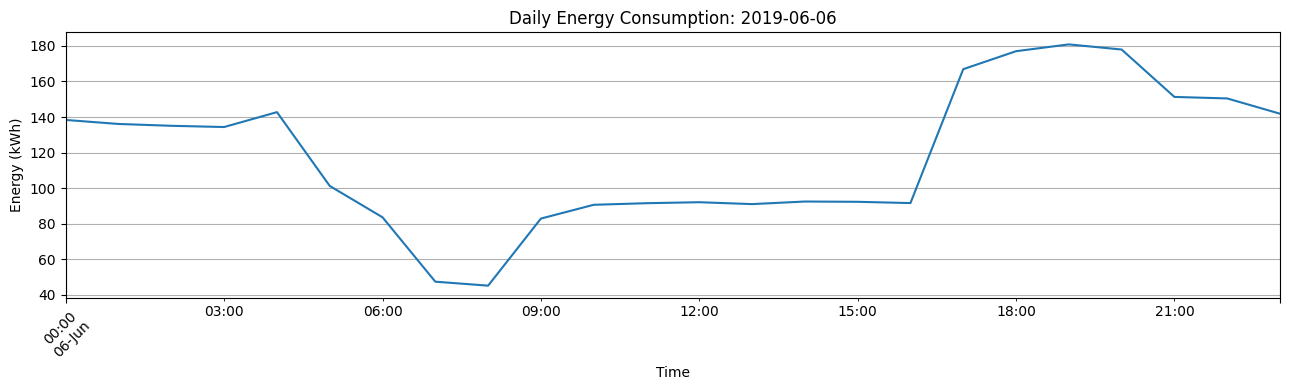

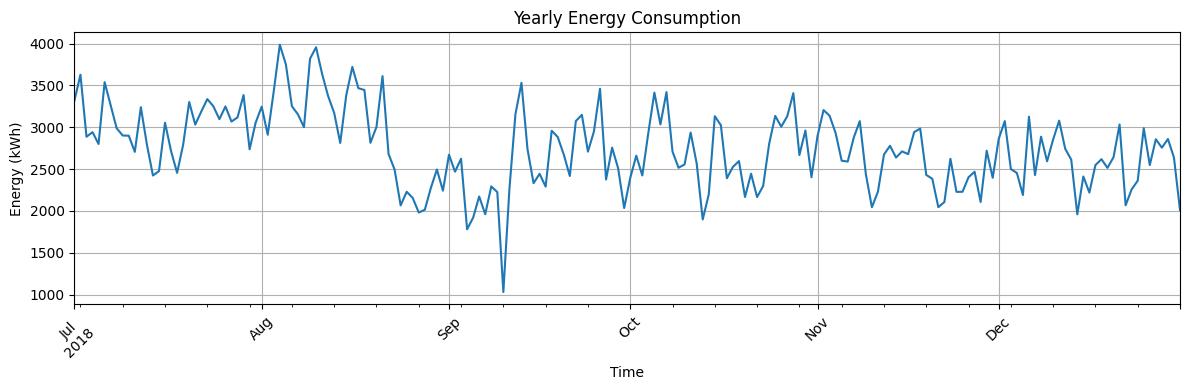

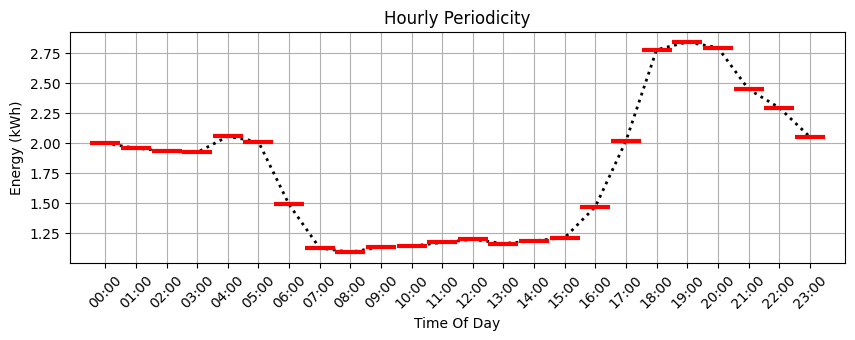

In [66]:
# Resample hourly - The value that represents each hour is the total energy consumed in that hour
floor1_hourly = floor1_df['total_consumption(kWh)'].resample('h').sum()

# Resample daily - The value that represents each day is the total energy consumed in that day
floor1_daily = floor1_df['total_consumption(kWh)'].resample('D').sum()

# Plot specific day
day_to_plot = '2019-06-06'

plt.figure(figsize=(13, 4))
floor1_hourly[day_to_plot:day_to_plot].plot()
plt.title(f'Daily Energy Consumption: {day_to_plot}')
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Specific Year
year_to_plot = '2018'

plt.figure(figsize=(12, 4))
floor1_daily[year_to_plot:year_to_plot].plot()
plt.title(f'Yearly Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# SEASONALITY
# Plotting Hourly Periodicity
avg_daily = floor1_df.groupby(floor1_df.index.hour)['total_consumption(kWh)'].mean()
plt.figure(figsize=(10, 3))
plt.plot(avg_daily.index, avg_daily.values, marker='_', markersize = 22, markeredgewidth=3, linestyle=':', linewidth=2, color='black', markeredgecolor='red')
plt.title('Hourly Periodicity')
plt.xlabel('Time Of Day')
plt.ylabel('Energy (kWh)')
hour_labels = [f"{h:02d}:00" for h in range(24)]  # 0:00 -> 24:00
plt.xticks(range(0, 24), hour_labels)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Preprocessing

Function for Interpolating a List

In [67]:
def interpolate_list(data, factor, kind):
    x = np.arange(len(data))

    f = interp1d(x, data, kind=kind)
    x_inter = np.linspace(0, len(data)-1, factor*len(data)-1)

    upsampled = f(x_inter)

    return upsampled

Creating Sampled Series

Models are trained for a specific sampling factor (2, 4, 8). Better than attempting to generalize a single model across multiple upsampling factors.

Models achieved the best performance when trained on data with daily resolution.

In [68]:
# Total Daily Energy
total_daily_energy = df['Energy_filled'].resample('D').sum()

# Total Energy every 12H (x2)
total_12H_energy = df['Energy_filled'].resample('12h').sum()

# Total Energy every 8H (x3)
# total_8H_energy = df['Energy_filled'].resample('8h').sum()

# Total Energy every 6H (x4)
total_6H_energy = df['Energy_filled'].resample('6h').sum()

# Total Energy every 288mins (x5)
# total_288min_energy = df['Energy_filled'].resample('288min').sum()

# Total Energy every 4H (x6)
# total_4H_energy = df['Energy_filled'].resample('4h').sum()

# Total Energy every 3H (x8)
total_3H_energy = df['Energy_filled'].resample('3h').sum()

# Total Hourly Energy
# total_hourly_energy = df['Energy_filled'].resample('h').sum()

# Total Energy every 30 minutes
# total_semihourly_energy = df['Energy_filled'].resample('30min').sum()

**Initial Upsampling**

Upsampling Low Frequency Series with Interpolation (Nearest) to the desired frequency. That makes the Low Frequency series have the same length as the High Frequency Series. Also, all values in interpolated series are divided by the upsampling factor so that the total energy in the timeseries remains the same.

In [69]:
# Picking which Series will be used
low_freq_series = total_daily_energy
match up_factor:
    case 2:
        high_freq_series = total_12H_energy
    case 4:
        high_freq_series = total_6H_energy
    case 8:
        high_freq_series = total_3H_energy

# Upsampling Factor
upsampling_factor = round(len(high_freq_series) / len(low_freq_series))

# Calculating length mismatch
length_diff1 = upsampling_factor*len(low_freq_series) - len(high_freq_series)
print("Length difference between high_freq_series and low_freq_series*upsampling_factor:", length_diff1, "\n")

# Alignment so that low_freq_series and high_freq_series start from the same index
low_freq_series = low_freq_series.iloc[1:]
high_freq_series = high_freq_series.iloc[upsampling_factor - length_diff1:]

# Upsample Low Freq Series with Interpolation
frequency = f"{1440 // upsampling_factor}min"     # 24h = 1440min
low_freq_interpolated = low_freq_series.resample(frequency).interpolate(method='nearest')
# print(frequency)

# Calculating length mismatch
length_diff2 = len(high_freq_series) - len(low_freq_interpolated)
print("Length difference between high_freq_series and low_freq_interpolated:", length_diff2, "\n")

# Repeat last value until the interpolated series has the same length as the high frequency series
for _ in range(length_diff2):
    low_freq_interpolated.loc[low_freq_interpolated.index[-1] + pd.Timedelta(frequency)] = low_freq_interpolated.iloc[-1]

# Dividing total energy by upsampling_factor
low_freq_interpolated = low_freq_interpolated/upsampling_factor

print("Upsampling Factor:", upsampling_factor, "\n")
print("High frequency Time Series Length:", len(high_freq_series))
print("Low frequency Time Series Length before Interpolation:", len(low_freq_series))
print("Low frequency Time Series Length after Interpolation:", len(low_freq_interpolated), "\n")

print("High frequency Time Series starts at:", high_freq_series.index[0], "and ends at", high_freq_series.index[-1])
print("Low frequency Time Series before Interpolation starts at:", low_freq_series.index[0], "and ends at", low_freq_series.index[-1])
print("Low frequency Time Series after Interpolation starts at:", low_freq_interpolated.index[0], "and ends at", low_freq_interpolated.index[-1], "\n")

print(f"Total Energy in High frequency Time Series: {high_freq_series.sum()/1000:.2f} MWh")
print(f"Total Energy in Low frequency Time Series before Interpolation: {low_freq_series.sum()/1000:.2f} MWh")
print(f"Total Energy in Low frequency Time Series after Interpolation: {low_freq_interpolated.sum()/1000:.2f} MWh")

Length difference between high_freq_series and low_freq_series*upsampling_factor: 2 

Length difference between high_freq_series and low_freq_interpolated: 3 

Upsampling Factor: 4 

High frequency Time Series Length: 5764
Low frequency Time Series Length before Interpolation: 1441
Low frequency Time Series Length after Interpolation: 5764 

High frequency Time Series starts at: 2006-12-17 00:00:00 and ends at 2010-11-26 18:00:00
Low frequency Time Series before Interpolation starts at: 2006-12-17 00:00:00 and ends at 2010-11-26 00:00:00
Low frequency Time Series after Interpolation starts at: 2006-12-17 00:00:00 and ends at 2010-11-26 18:00:00 

Total Energy in High frequency Time Series: 37.69 MWh
Total Energy in Low frequency Time Series before Interpolation: 37.69 MWh
Total Energy in Low frequency Time Series after Interpolation: 37.68 MWh


Visualizing timeseries after initial upsampling

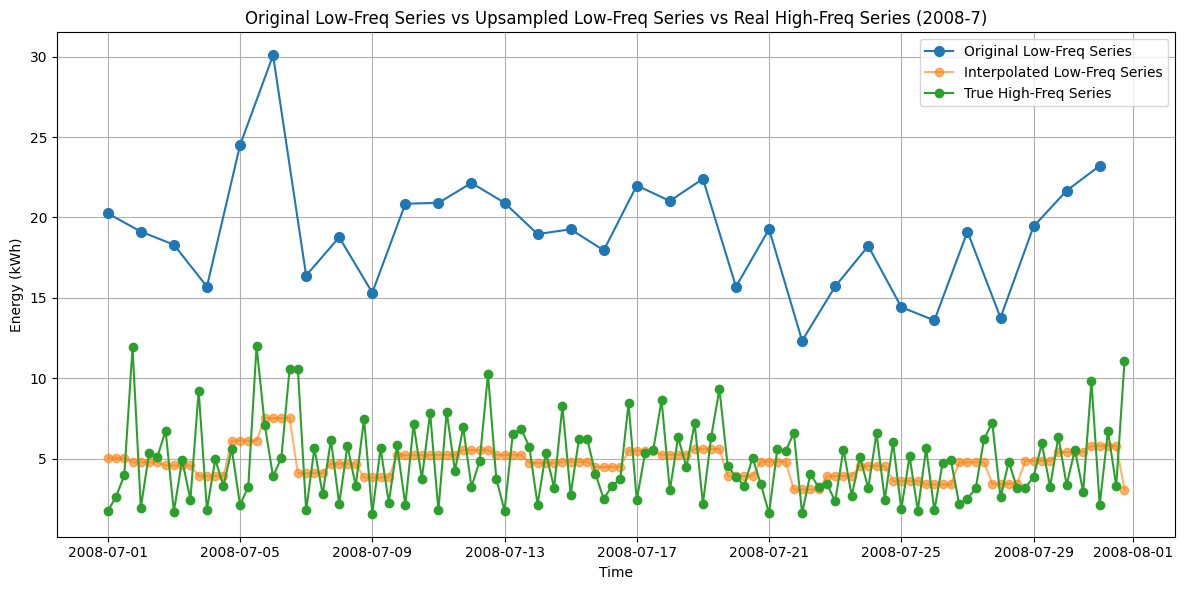

In [70]:
# Select Time Span
time_span = '2008-7'

plt.figure(figsize=(12, 6))
plt.plot(low_freq_series[time_span].index, low_freq_series[time_span].values, 'o-', label='Original Low-Freq Series', markersize=7)
plt.plot(low_freq_interpolated[time_span].index, low_freq_interpolated[time_span].values, 'o-', label='Interpolated Low-Freq Series', alpha=0.6)
plt.plot(high_freq_series[time_span].index, high_freq_series[time_span].values, 'o-', label='True High-Freq Series', alpha=1)

plt.title(f"Original Low-Freq Series vs Upsampled Low-Freq Series vs Real High-Freq Series ({time_span})")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Train-Validation-Test Split**

In [71]:
# Convert Series to Arrays
low_freq_values = low_freq_series.values
low_freq_inter_values = low_freq_interpolated.values    # Features
high_freq_values = high_freq_series.values              # Targets

# Creating Train, Validation, Test sets
train_ratio = 0.75
val_ratio = 0.15
test_ratio = 1 - train_ratio - val_ratio

train_end_idx = int(len(low_freq_inter_values) * train_ratio)
val_end_idx = train_end_idx + int(len(low_freq_inter_values) * val_ratio)

X_train = low_freq_inter_values[:train_end_idx]
y_train = high_freq_values[:train_end_idx]

X_val = low_freq_inter_values[train_end_idx:val_end_idx]
y_val = high_freq_values[train_end_idx:val_end_idx]

X_test = low_freq_inter_values[val_end_idx:]
y_test = high_freq_values[val_end_idx:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4323,)
y_train shape: (4323,)
X_val shape: (864,)
y_val shape: (864,)
X_test shape: (577,)
y_test shape: (577,)


**Min-Max Scaling**

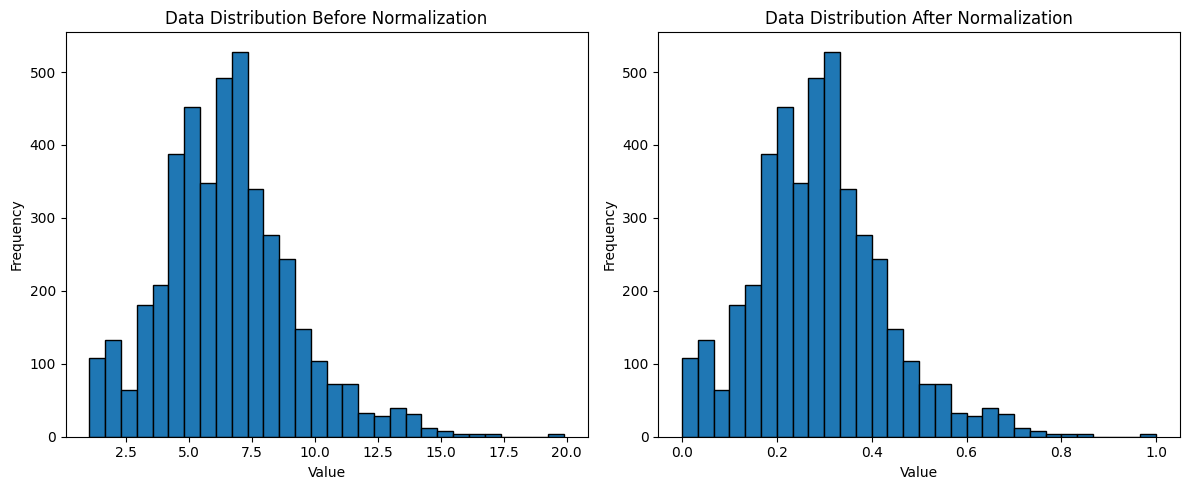


Feature Series Energy after Normalization: 1.6805
Target Series Energy after Normalization: 1.6809


In [72]:
# Normalizing Train, Val, Test Sets in the range 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fitting Transform on all sets
X_train_norm = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(-1)
y_train_norm = scaler.transform(y_train.reshape(-1, 1)).reshape(-1)

X_val_norm = scaler.transform(X_val.reshape(-1, 1)).reshape(-1)
y_val_norm = scaler.transform(y_val.reshape(-1, 1)).reshape(-1)

X_test_norm = scaler.transform(X_test.reshape(-1, 1)).reshape(-1)
y_test_norm = scaler.transform(y_test.reshape(-1, 1)).reshape(-1)

# Creating Histograms to show that data distribution is preserved
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Before Normalization
axs[0].hist(X_train, bins=30, edgecolor='black')
axs[0].set_title("Data Distribution Before Normalization")
axs[0].set_xlabel("Value")
axs[0].set_ylabel("Frequency")

# After Normalization
axs[1].hist(X_train_norm, bins=30, edgecolor='black')
axs[1].set_title("Data Distribution After Normalization")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Showing that the total energy relation between features and targets is preserved
print(f'\nFeature Series Energy after Normalization: {(sum(X_test_norm) + sum(X_train_norm) + sum(X_val_norm))/1000:.4f}')
print(f'Target Series Energy after Normalization: {(sum(y_test_norm) + sum(y_train_norm) + sum(y_val_norm))/1000:.4f}')

**Data Augmentation**

Creating more sequences for training by splitting sets into smaller sequences

In [73]:
# Sliding Window Function (Create overlapping sequences if stride < window_size)
def sliding_window(input_series, window_size, stride):
    X = []

    num_samples = (len(input_series) - window_size) // stride + 1

    for i in range(0, num_samples * stride, stride):
        X.append(input_series[i: i + window_size])

    return np.array(X)

def split_into_sequences(input_series, seq_length):

    # Pad the input sequence with zeros so that we can split it evenly
    num_sequences = int(np.ceil(len(input_series) / seq_length))
    padded_len = num_sequences * seq_length
    padded_seq = np.pad(input_series, (0, padded_len - len(input_series)), mode='constant')

    # Reshape sequence into 2d array with num_sequences rows and seq_length columns
    sequences = padded_seq.reshape(num_sequences, seq_length)

    return sequences

In [74]:
# Feature and Target Sequences' Length
sequence_length = 150
stride = 1

# Split into overlapping sequences for more training data
train_seqs = sliding_window(X_train_norm, sequence_length, stride)
train_target_seqs = sliding_window(y_train_norm, sequence_length, stride)

# Split into non-overlapping sequences
val_seqs = split_into_sequences(X_val_norm, sequence_length)
val_target_seqs = split_into_sequences(y_val_norm, sequence_length)
test_seqs = split_into_sequences(X_test_norm, sequence_length)
test_target_seqs = split_into_sequences(y_test_norm, sequence_length)

print("Train Sequences Shape:", train_seqs.shape)
print("Train Target Sequences Shape:", train_target_seqs.shape)
print("Validation Sequences Shape:", val_seqs.shape)
print("Validation Target Sequences Shape:", val_target_seqs.shape)
print("Test Sequences Shape:", test_seqs.shape)
print("Test Target Sequences Shape:", test_target_seqs.shape)

Train Sequences Shape: (4174, 150)
Train Target Sequences Shape: (4174, 150)
Validation Sequences Shape: (6, 150)
Validation Target Sequences Shape: (6, 150)
Test Sequences Shape: (4, 150)
Test Target Sequences Shape: (4, 150)


(Optional) Creating even more sequences by adding noise to existing ones

In [75]:
def add_noise_to_sequences(input_array, num_new_seqs, noise_level):
    noisy_sequences = []
    for i in range(num_new_seqs):
        # Pick a random sequence
        rand_idx = random.randint(0, len(input_array) - 1)

        # Add noise to it
        new_seq = input_array[rand_idx] + np.random.normal(0, noise_level, size=input_array[rand_idx].shape)

        # Clip the values so they stay in the normalized range
        new_seq = np.clip(new_seq, 0, 1)

        # Add the new sequence to an array
        noisy_sequences.append(new_seq)

    if num_new_seqs != 0:
        # Add the noisy sequences at the end of the array
        input_array = np.vstack((input_array, noisy_sequences))

    return input_array

In [76]:
# Parameters
num_seqs_to_add = 0
noise = 0.01

train_seqs = add_noise_to_sequences(train_seqs, num_seqs_to_add, noise)
train_target_seqs = add_noise_to_sequences(train_target_seqs, num_seqs_to_add, noise)

print("Train Sequences Shape:", train_seqs.shape)
print("Train Target Sequences Shape:", train_target_seqs.shape)

Train Sequences Shape: (4174, 150)
Train Target Sequences Shape: (4174, 150)


# Dataset Class

In [77]:
class EnergyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # shape: (N, sequence_length, 1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # shape: (N, sequence_length, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Models


In [78]:
#--------------------------------------------------------------------------------------------------------------------------------------
# Model 1 (Seq2Seq LSTM Model based on the paper "Sequence to Sequence Learning with Neural Networks" and Ben Trevett's Implementation)
class Encoder1(nn.Module):
    def __init__(self, input_size, hidden_size, mapping_size, num_layers, dropout):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.mapping_size = mapping_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)

        # Projection of the 1d input features to mapping_size dimensional space
        self.input_mapping = nn.Linear(input_size, mapping_size)

        self.rnn = nn.LSTM(mapping_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)

        x = self.input_mapping(x)
        # x shape: (batch_size, sequence_length, mapping_size)

        outputs, (hidden, cell) = self.rnn(self.dropout(x))
        # output shape: (batch_size, sequence_length, hidden_size)
        # (hidden, cell) -> Context Vector
        # hidden shape: (num_layers, batch_size, hidden_size)
        # cell shape: (num_layers, batch_size, hidden_size)

        return hidden, cell


class Decoder1(nn.Module):
    def __init__(self, output_size, hidden_size, mapping_size, num_layers, dropout):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.mapping_size = mapping_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)

        # Projection of the 1d input features to mapping_size dimensional space
        self.input_mapping = nn.Linear(output_size, mapping_size)

        self.rnn = nn.LSTM(mapping_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

        # Projection of hidden_size to mapping_size and then to output_size
        self.output_mapping = nn.Sequential(
            nn.Linear(hidden_size, mapping_size),
            nn.ReLU(),
            nn.Linear(mapping_size, output_size)
        )

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        # x shape: (batch_size, 1, input_size) sequence_length = 1 because we feed one timestep at a time

        x = self.input_mapping(x)
        # x shape: (batch_size, 1, mapping_size)

        outputs, (hidden, cell) = self.rnn(self.dropout(x), (hidden, cell))
        # output shape: (batch_size, 1, hidden_size)
        # hidden shape: (num_layers, batch_size, hidden_size)
        # cell shape: (num_layers, batch_size, hidden_size)

        predictions = self.output_mapping(outputs)
        # predictions shape: (batch_size, 1, output_size)

        return predictions, hidden, cell


class Seq2Seq1(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target, teacher_forcing_ratio = 0.5):
        # source shape: (batch_size, seq_len, input_size)
        # target shape: (batch_size, seq_len, output_size)
        # teacher_forcing_ratio is the probability to use true target value for the input instead of the last predicted value
        batch_size = source.shape[0]
        target_length = target.shape[1]
        output_size = self.decoder.output_size

        # For Storing decoder outputs
        outputs = torch.zeros(batch_size, target_length, output_size).to(self.device)

        # Get last hidden, cell from the encoder
        hidden, cell = self.encoder(source)

        # First input to the decoder is the first timestep of target sequence (In the training)
        input = target[:, 0, :]
        # input shape: (batch_size, output_size)

        for t in range(1, target_length):
            # Get Prediction and hidden, cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output: (batch_size, 1, output_size)
            output = output.squeeze(1)
            # output: (batch_size, output_size)

            # Store prediction
            outputs[:, t, :] = output

            # Decide if teacher forcing will be used
            teacher_force = random.random() < teacher_forcing_ratio

            input = target[:, t, :] if teacher_force else output
            # input shape: (batch_size, output_size)

        return outputs


#--------------------------------------------------------------------------------------------------------------------------------------
# Model 2 (Seq2Seq with Attention)
class AttentionEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, mapping_size, num_layers, dropout):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.mapping_size = mapping_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)

        # Projection of the 1d input features to mapping_size dimensional space
        self.input_mapping = nn.Linear(input_size, mapping_size)

        self.rnn = nn.LSTM(mapping_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)

        x = self.input_mapping(x)
        # x shape: (batch_size, sequence_length, mapping_size)

        outputs, (hidden, cell) = self.rnn(self.dropout(x))
        # output shape: (batch_size, sequence_length, hidden_size)
        # (hidden, cell) -> Context Vector
        # hidden shape: (num_layers, batch_size, hidden_size)
        # cell shape: (num_layers, batch_size, hidden_size)

        return outputs, hidden, cell  # Encoder needs to return outputs for the attention mechanism

class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()

        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden shape: (batch_size, hidden_size)
        # encoder_outputs shape: (batch_size, seq_length, hidden_size)
        batch_size = encoder_outputs.shape[0]
        seq_length = encoder_outputs.shape[1]

        hidden = hidden.unsqueeze(1).repeat(1, seq_length, 1)
        # hidden shape: (batch_size, seq_length, hidden_size)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy shape: (batch_size, seq_length, hidden_size)

        attention = self.v(energy).squeeze(2)
        # attention shape: (batch_size, seq_length)

        return torch.softmax(attention, dim=1)

class AttentionDecoder(nn.Module):
    def __init__(self, output_size, hidden_size, mapping_size, num_layers, attention, dropout):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.mapping_size = mapping_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = nn.Dropout(dropout)

        # Projection of the 1d input features to mapping_size dimensional space
        self.input_mapping = nn.Linear(output_size, mapping_size)

        self.rnn = nn.LSTM(mapping_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

        # Projection of 2*hidden_size to mapping_size and then to output_size
        self.output_mapping = nn.Sequential(
            nn.Linear(hidden_size * 2, mapping_size),
            nn.ReLU(),
            nn.Linear(mapping_size, output_size)
        )

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)
        # (batch_size, 1, output_size)

        x = self.input_mapping(x)
        # x shape: (batch_size, 1, mapping_size)

        # Run RNN
        outputs, (hidden, cell) = self.rnn(self.dropout(x), (hidden, cell))
        # outputs: (batch_size, 1, hidden_size)

        # Compute attention weights
        attn_weights = self.attention(outputs.squeeze(1), encoder_outputs)
        # attn_weights: (batch_size, seq_length)

        # Weighted sum of encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        # context: (batch_size, 1, hidden_size)

        # Concatenate context and RNN output
        combined = torch.cat((outputs, context), dim=2)
        predictions = self.output_mapping(combined)  # (batch_size, 1, output_size)

        return predictions, hidden, cell, attn_weights

class AttentionSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target, teacher_forcing_ratio):
        # source shape: (batch_size, seq_length, input_size)
        # target shape: (batch_size, seq_length, output_size)
        batch_size = source.shape[0]
        target_length = target.shape[1]
        output_size = self.decoder.output_size

        # For Storing decoder outputs
        outputs = torch.zeros(batch_size, target_length, output_size).to(self.device)

        # Get last outputs, hidden, cell from the encoder
        encoder_outputs, hidden, cell = self.encoder(source)

        # First input to the decoder is the first timestep of target sequence (In the training)
        input = target[:, 0, :]
        # input shape: (batch_size, output_size)

        for t in range(1, target_length):
            # Get Prediction and hidden, cell states
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs)
            # output: (batch_size, 1, output_size)
            output = output.squeeze(1)
            # output: (batch_size, output_size)

            # Store prediction
            outputs[:, t, :] = output

            # Decide if teacher forcing will be used
            teacher_force = random.random() < teacher_forcing_ratio

            input = target[:, t, :] if teacher_force else output
            # input shape: (batch_size, output_size)

        return outputs

#--------------------------------------------------------------------------------------------------------------------------------------
# Model 3 (4 Layer 1d CNN with Residual Connection)
class ResidualConv1d(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, kernel_sizes, dropout):
        super().__init__()

        self.net = nn.Sequential(
            # input shape: (batch_size, input_size=1, seq_length)

            nn.Conv1d(input_size, hidden_size, kernel_size=kernel_sizes[0], padding='same'),
            nn.ReLU(),
            nn.Dropout(dropout),
            # shape: (batch_size, hidden_size, seq_length)

            nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_sizes[1], padding='same'),
            nn.ReLU(),
            nn.Dropout(dropout),
            # shape: (batch_size, hidden_size, seq_length)

            nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_sizes[2], padding='same'),
            nn.ReLU(),
            nn.Dropout(dropout),
            # shape: (batch_size, hidden_size, seq_length)

            nn.Conv1d(hidden_size, output_size, kernel_size=kernel_sizes[3])  # output mapping
            # shape: (batch_size, output_size=1, seq_length)
        )

    def forward(self, x):
        # x shape: (batch_size, input_size, seq_length) permuted in the train-val functions

        output_sequence = x + self.net(x)       # Network just refines the input seq to match the target seq
        # output shape: (batch_size, output_size, seq_length)

        return output_sequence

#--------------------------------------------------------------------------------------------------------------------------------------
# Model 4 (4 Layer 1d CNN without Residual Connection)
class BasicConv1d(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, kernel_sizes, dropout):
        super().__init__()

        self.net = nn.Sequential(
            # input shape: (batch_size, input_size=1, seq_length)

            nn.Conv1d(input_size, hidden_size, kernel_size=kernel_sizes[0], padding='same'),
            nn.ReLU(),
            nn.Dropout(dropout),
            # shape: (batch_size, hidden_size, seq_length)

            nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_sizes[1], padding='same'),
            nn.ReLU(),
            nn.Dropout(dropout),
            # shape: (batch_size, hidden_size, seq_length)

            nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_sizes[2], padding='same'),
            nn.ReLU(),
            nn.Dropout(dropout),
            # shape: (batch_size, hidden_size, seq_length)

            nn.Conv1d(hidden_size, output_size, kernel_size=kernel_sizes[3])  # output mapping
            # shape: (batch_size, output_size=1, seq_length)
        )

    def forward(self, x):
        # x shape: (batch_size, input_size, seq_length) permuted in the train-val functions

        output_sequence = self.net(x)
        # output shape: (batch_size, output_size, seq_length)

        return output_sequence

#--------------------------------------------------------------------------------------------------------------------------------------
# Model 5 (4 Layer 1d CNN with Residual Connection and Dilation)
class DilationConv1d(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, kernel_sizes, dropout):
        super().__init__()

        self.net = nn.Sequential(
            # input shape: (batch_size, input_size=1, seq_length)

            nn.Conv1d(input_size, hidden_size, kernel_size=kernel_sizes[0], dilation=1 , padding='same'),
            nn.ReLU(),
            nn.Dropout(dropout),
            # shape: (batch_size, hidden_size, seq_length)

            nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_sizes[1], dilation=2, padding='same'),
            nn.ReLU(),
            nn.Dropout(dropout),
            # shape: (batch_size, hidden_size, seq_length)

            nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_sizes[2], dilation=4, padding='same'),
            nn.ReLU(),
            nn.Dropout(dropout),
            # shape: (batch_size, hidden_size, seq_length)

            nn.Conv1d(hidden_size, output_size, kernel_size=kernel_sizes[3])  # output mapping
            # shape: (batch_size, output_size=1, seq_length)
        )

    def forward(self, x):
        # x shape: (batch_size, input_size, seq_length) permuted in the train-val functions

        output_sequence = x + self.net(x)       # Network just refines the input seq to match the target seq
        # output shape: (batch_size, output_size, seq_length)

        return output_sequence

#--------------------------------------------------------------------------------------------------------------------------------------
# Model 6 (Model based on original UNet autoencoder modified for 1d signals)
class UNet1D(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, kernel_size):
        super().__init__()

        # Encoder (With padding='same' so each sequence stays the same, unlike original UNet)
        self.encoder1 = nn.Sequential(
            nn.Conv1d(input_size, hidden_size, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size, padding='same'),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv1d(hidden_size, hidden_size*2, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv1d(hidden_size*2, hidden_size*2, kernel_size, padding='same'),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Bottleneck (With padding='same' so each sequence stays the same, unlike original UNet)
        self.bottleneck = nn.Sequential(
            nn.Conv1d(hidden_size*2, hidden_size*4, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv1d(hidden_size*4, hidden_size*4, kernel_size, padding='same'),
            nn.ReLU()
        )

        # Decoder (With padding='same' so each sequence stays the same, unlike original UNet)
        self.up2 = nn.Upsample(scale_factor=2, mode='linear', align_corners=False)
        self.decoder2 = nn.Sequential(
            nn.Conv1d(hidden_size*4 + hidden_size*2, hidden_size*2, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv1d(hidden_size*2, hidden_size*2, kernel_size, padding='same'),
            nn.ReLU()
        )

        self.up1 = nn.Upsample(scale_factor=2, mode='linear', align_corners=False)
        self.decoder1 = nn.Sequential(
            nn.Conv1d(hidden_size*2 + hidden_size, hidden_size, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv1d(hidden_size, output_size, kernel_size, padding='same')
        )

    def forward(self, x):
        # x shape: (batch_size, input_size, seq_length) permuted in the train-val functions

        # Encoder
        e1 = self.encoder1(x)               # shape: (batch_size, hidden_size, seq_length)
        e2 = self.encoder2(self.pool1(e1))  # shape: (batch_size, hidden_size*2, seq_length/2)

        # Bottleneck
        b = self.bottleneck(self.pool2(e2)) # shape: (batch_size, hidden_size*4, seq_length/4)

        # Decoder
        d2 = self.up2(b)                    # shape: (batch_size, hidden_size*4, seq_length/2)

        # Make sure the sizes of encoder and decoder outputs match for the copy step
        if d2.size(-1) != e2.size(-1):
            d2 = F.interpolate(d2, size=e2.size(-1), mode='linear', align_corners=False)
        d2 = torch.cat([d2, e2], dim=1)  # "crop" and copy

        d2 = self.decoder2(d2)              # shape: (batch_size, hidden_size*2, seq_length/2)
        d1 = self.up1(d2)                   # shape: (batch_size, hidden_size*2, seq_length)

        if d1.size(-1) != e1.size(-1):
            d1 = F.interpolate(d1, size=e1.size(-1), mode='linear', align_corners=False)
        d1 = torch.cat([d1, e1], dim=1)  # "crop" and copy

        out = self.decoder1(d1)             # shape: (batch_size, output_size, seq_length)

        # Model refines the input (Residual Connection)
        return x + out

# Model Initialization

Set Device

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is:", device)

Device is: cuda


In [80]:
match model_id:
    case 0:
        # ------ Seq2Seq LSTM Model ------ #
        # Model Hyperparameters
        input_size = 1
        output_size = 1
        hidden_size = 128
        mapping_size = 256
        num_layers = 2
        dropout = 0.2 # non-zero dropout only if num_layers > 1

        # Initialization
        encoder = Encoder1(
            input_size,
            hidden_size,
            mapping_size,
            num_layers,
            dropout=dropout
        )

        decoder = Decoder1(
            output_size,
            hidden_size,
            mapping_size,
            num_layers,
            dropout=dropout
        )

        model = Seq2Seq1(encoder, decoder, device).to(device)
        print(model)

        # Number of Trainable Parameters
        def count_parameters(model):
            return sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"Model {model_id} has {count_parameters(model):,} trainable parameters.")

    case 1:
        # ------ Seq2Seq LSTM Model with Attention ------ #
        # Model Hyperparameters
        input_size = 1
        output_size = 1
        hidden_size = 128
        mapping_size = 256
        num_layers = 2
        dropout = 0.2 # non-zero dropout only if num_layers > 1

        # Initialization
        attention = Attention(hidden_size, hidden_size)

        encoder = AttentionEncoder(
            input_size,
            hidden_size,
            mapping_size,
            num_layers,
            dropout=dropout
        )

        decoder = AttentionDecoder(
            output_size,
            hidden_size,
            mapping_size,
            num_layers,
            attention=attention,
            dropout=dropout
        )

        model = AttentionSeq2Seq(encoder, decoder, device).to(device)
        print(model)

        # Number of Trainable Parameters
        def count_parameters(model):
            return sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"Model {model_id} has {count_parameters(model):,} trainable parameters.")

    case 2:
        # ------ Residual 1D CNN ------ #
        # Model Hyperparameters
        input_size = 1
        output_size = 1
        hidden_size = 64
        kernel_sizes = [7,7,7,1]
        dropout = 0.5

        # Initialization
        model = ResidualConv1d(input_size, output_size, hidden_size, kernel_sizes, dropout).to(device)

        # Number of Trainable Parameters
        def count_parameters(model):
            return sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"Model {model_id} has {count_parameters(model):,} trainable parameters.")

        # Model Graph
        # example_input = torch.randn(64, 1, 10)
        # trace_model(model,
        #   example_input,
        #   height=800,
        #   width=400,
        #   export_format=None,
        #   show_compressed_view=True)

    case 3:
        # ------ 1D CNN ------ #
        # Model Hyperparameters
        input_size = 1
        output_size = 1
        hidden_size = 64
        kernel_sizes = [7,7,7,1]
        dropout = 0.5

        # Initialization
        model = BasicConv1d(input_size, output_size, hidden_size, kernel_sizes, dropout).to(device)

        # Number of Trainable Parameters
        def count_parameters(model):
            return sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"Model {model_id} has {count_parameters(model):,} trainable parameters.")

        # Model Graph
        # example_input = torch.randn(64, 1, 10)
        # trace_model(model,
        #   example_input,
        #   height=800,
        #   width=400,
        #   export_format=None,
        #   show_compressed_view=True)

    case 4:
        # ------ 1D Dilation CNN ------ #
        # Model Hyperparameters
        input_size = 1
        output_size = 1
        hidden_size = 64
        kernel_sizes = [5,5,5,1]
        dropout = 0.25

        # Initialization
        model = DilationConv1d(input_size, output_size, hidden_size, kernel_sizes, dropout).to(device)

        # Number of Trainable Parameters
        def count_parameters(model):
            return sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"Model {model_id} has {count_parameters(model):,} trainable parameters.")

        # Model Graph
        # example_input = torch.randn(64, 1, 10)
        # trace_model(model,
        #   example_input,
        #   height=800,
        #   width=400,
        #   export_format=None,
        #   show_compressed_view=True)

    case 5:
        # ------ 1D UNet ------ #
        # Model Hyperparameters
        input_size = 1
        output_size = 1
        hidden_size = 64
        kernel_size = 3

        # Initialization
        model = UNet1D(input_size, output_size, hidden_size, kernel_size).to(device)

        # Number of Trainable Parameters
        def count_parameters(model):
            return sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"Model {model_id} has {count_parameters(model):,} trainable parameters.")

        # Model Graph
        # example_input = torch.randn(64, 1, 10)
        # trace_model(model,
        #   example_input,
        #   height=800,
        #   width=400,
        #   export_format=None,
        #   show_compressed_view=True)

Model 3 has 58,049 trainable parameters.


In [81]:
# Export model in .onnx format
# torch.onnx.export(model, torch.randn(64, 1, 10), 'unet.onnx', input_names=["input sequence"], output_names=["output sequence"])

Initialize Weights

In [82]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

BasicConv1d(
  (net): Sequential(
    (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=same)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=same)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
  )
)

# Training - Validation

Train-Val Functions for every model

In [83]:
match model_id:
  case 0 | 1:
      # For LSTM Models
      # Train Function
      def train_one_epoch(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device, train_losses):

          model.train()
          train_loss = 0
          for i, batch in enumerate(data_loader):
              X_batch, Y_batch = batch

              X_batch = X_batch.to(device)
              Y_batch = Y_batch.to(device)
              # X_batch shape: (batch_size, sequence_length, input_size)
              # Y_batch shape: (batch_size, sequence_length, input_size)

              optimizer.zero_grad()

              output = model(X_batch, Y_batch, teacher_forcing_ratio)
              # output shape: (batch_size, target_sequence_length, output_size)

              loss = criterion(output, Y_batch)
              loss.backward()

              # Clipping the gradients to prevent them from exploding
              torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
              optimizer.step()

              train_loss += loss.item()

          avg_train_loss = train_loss / len(data_loader)
          train_losses.append(avg_train_loss)

          return avg_train_loss

      # Validation Function
      def val_one_epoch(model, data_loader, criterion, device, val_losses):
          model.eval()

          val_loss = 0
          with torch.no_grad():
              for i, batch in enumerate(data_loader):
                  X_batch, Y_batch = batch

                  X_batch = X_batch.to(device)
                  Y_batch = Y_batch.to(device)

                  # Disable teacher forcing
                  output = model(X_batch, Y_batch, teacher_forcing_ratio=0)

                  loss = criterion(output, Y_batch)
                  val_loss += loss.item()

          avg_val_loss = val_loss / len(data_loader)
          val_losses.append(avg_val_loss)

          return avg_val_loss

      print("Functions loaded for Model 0 and 1")

  case 2 | 3 | 4 | 5:
      # For 1d CNN Models
      # Train Function
      def train_one_epoch(model, data_loader, optimizer, criterion, clip, device, train_losses):

          model.train()
          train_loss = 0
          for i, batch in enumerate(data_loader):
              X_batch, Y_batch = batch

              # Permute to (batch, channels, seq_length) for Conv1d
              X_batch = X_batch.permute(0, 2, 1).to(device)
              Y_batch = Y_batch.permute(0, 2, 1).to(device)

              X_batch = X_batch.to(device)
              Y_batch = Y_batch.to(device)

              optimizer.zero_grad()

              output = model(X_batch)
              # output shape: (batch_size, target_sequence_length, output_size)

              loss = criterion(output, Y_batch)
              loss.backward()

              # Clipping the gradients to prevent them from exploding
              torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
              optimizer.step()

              train_loss += loss.item()

          avg_train_loss = train_loss / len(data_loader)
          train_losses.append(avg_train_loss)


          return avg_train_loss

      # Validation Function
      def val_one_epoch(model, data_loader, criterion, device, val_losses):
          model.eval()

          val_loss = 0
          with torch.no_grad():
              for i, batch in enumerate(data_loader):
                  X_batch, Y_batch = batch

                  # Permute to (batch, channels, seq_length) for Conv1d
                  X_batch = X_batch.permute(0, 2, 1).to(device)
                  Y_batch = Y_batch.permute(0, 2, 1).to(device)

                  X_batch = X_batch.to(device)
                  Y_batch = Y_batch.to(device)

                  output = model(X_batch)

                  loss = criterion(output, Y_batch)
                  val_loss += loss.item()

          avg_val_loss = val_loss / len(data_loader)
          val_losses.append(avg_val_loss)

          return avg_val_loss
      print("Functions loaded for Model 2, 3 and 4")

Functions loaded for Model 2, 3 and 4


# Train-Val Loop

In [84]:
# Training Hyperparameters
epochs = 5
epochs_range = range(1, epochs + 1)
patience = 30
clip=1
teacher_forcing_ratio = 0.5

learning_rate = 0.005
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Scheduler to reduce learning rate if val loss plateaus
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Datasets
batch_size = 64
train_dataset = EnergyDataset(train_seqs, train_target_seqs)
val_dataset = EnergyDataset(val_seqs, val_target_seqs)

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Store losses
train_losses = []
val_losses = []

best_valid_loss = float('inf')
epochs_no_improv = 0

# Train Loop
match model_id:
    case 0 | 1:
        # For Seq2Seq LSTM Models
        for epoch in tqdm.tqdm(epochs_range):
            train_loss = train_one_epoch(model,
                                        train_dataloader,
                                        optimizer,
                                        criterion,
                                        clip,
                                        teacher_forcing_ratio,
                                        device=device,
                                        train_losses=train_losses)

            val_loss = val_one_epoch(model,
                                    val_dataloader,
                                    criterion,
                                    device=device,
                                    val_losses=val_losses)

            if val_loss < best_valid_loss:
                best_valid_loss = val_loss
                epochs_no_improv = 0
            else:
                epochs_no_improv += 1

            if epochs_no_improv >= patience:
                break

            print(f"\n\tTrain Loss = {train_loss:.6f}\n\tVal Loss = {val_loss:.6f}")
    case 2 | 3 | 4 | 5:
        # For 1D CNN Models
        for epoch in tqdm.tqdm(epochs_range):
            train_loss = train_one_epoch(model,
                                        train_dataloader,
                                        optimizer,
                                        criterion,
                                        clip,
                                        device=device,
                                        train_losses=train_losses)

            val_loss = val_one_epoch(model,
                                    val_dataloader,
                                    criterion,
                                    device=device,
                                    val_losses=val_losses)

            # Scheduler
            # scheduler.step(val_loss)

            if val_loss < best_valid_loss:
                best_valid_loss = val_loss
                epochs_no_improv = 0
            else:
                epochs_no_improv += 1

            if epochs_no_improv >= patience:
                break

            print(f"\n\tTrain Loss = {train_loss:.6f}\n\tVal Loss = {val_loss:.6f}")

print(f"\nTraining finished in {epoch} Epochs.\nBest Validation Loss: {best_valid_loss:.6f}")

 20%|██        | 1/5 [00:00<00:03,  1.28it/s]


	Train Loss = 0.050020
	Val Loss = 0.031621


 40%|████      | 2/5 [00:01<00:02,  1.30it/s]


	Train Loss = 0.037074
	Val Loss = 0.030276


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]


	Train Loss = 0.033016
	Val Loss = 0.019794


 80%|████████  | 4/5 [00:03<00:00,  1.31it/s]


	Train Loss = 0.024291
	Val Loss = 0.015134


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


	Train Loss = 0.021292
	Val Loss = 0.013753

Training finished in 5 Epochs.
Best Validation Loss: 0.013753


Plotting Training-Validation Loss Curves

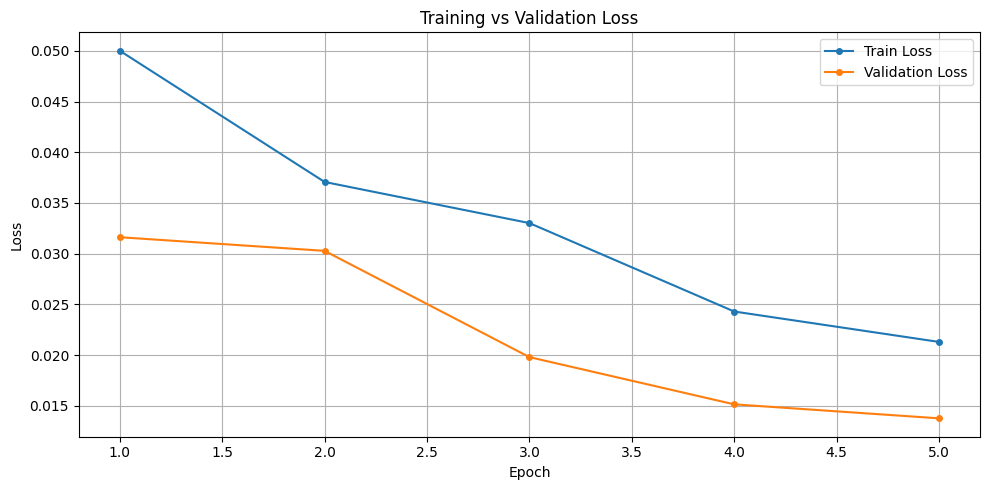

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch + 1), train_losses, label='Train Loss', marker='o', markersize = 4)
plt.plot(range(1, epoch + 1), val_losses, label='Validation Loss', marker='o', markersize = 4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Make Predictions

Prediction Functions

In [86]:
match model_id:
    case 0:
        # ------ Prediction function for Normal Seq2Seq Model ------ #
        def predict_sequence(model, input_sequence):
            # input_sequence shape: (sequence_length)

            model.eval()

            # Convert input sequence to tensor
            input_sequence = torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            # input_sequence shape: (1, sequence_length, 1)

            # Initialize tensor for storing predicted sequence
            output_sequence = torch.zeros(input_sequence.shape).to(device)
            # output_sequence shape: (1, sequence_length, 1)
            output_sequence_length = output_sequence.shape[1]

            with torch.no_grad():
                # Encode input sequence with the encoder to get hidden, cell states
                hidden, cell = model.encoder(input_sequence)

                # First decoder input is the first value of the input sequence
                decoder_input = input_sequence[:, 0, :]
                # decoder_input shape: (1, 1)

                # Predict output sequence one timestep at a time
                for t in range(0, output_sequence_length):
                    output, hidden, cell = model.decoder(decoder_input, hidden, cell)
                    output = output.squeeze(1)

                    # Store prediction
                    output_sequence[:, t, :] = output

                    # Next decoder input is the previous decoder output
                    decoder_input = output

            return output_sequence.squeeze(0).cpu().numpy()   # output_sequence shape: (sequence_length, 1)
    case 1:
        # ------ Prediction function for Attention Model ------ #
        def predict_sequence(model, input_sequence):
            # input_sequence shape: (sequence_length)

            model.eval()

            # Convert input sequence to tensor
            input_sequence = torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            # input_sequence shape: (1, sequence_length, 1)

            # Initialize tensor for storing predicted sequence
            output_sequence = torch.zeros(input_sequence.shape).to(device)
            # output_sequence shape: (1, sequence_length, 1)
            output_sequence_length = output_sequence.shape[1]

            with torch.no_grad():
                # Encode input sequence with the encoder to get hidden, cell states
                encoder_outputs, hidden, cell = model.encoder(input_sequence)

                # First decoder input is the first value of the input sequence
                decoder_input = input_sequence[:, 0, :]
                # decoder_input shape: (1, 1)

                # Predict output sequence one timestep at a time
                for t in range(0, output_sequence_length):
                    output, hidden, cell, _ = model.decoder(decoder_input, hidden, cell, encoder_outputs)
                    output = output.squeeze(1)

                    # Store prediction
                    output_sequence[:, t, :] = output

                    # Next decoder input is the previous decoder output
                    decoder_input = output

            return output_sequence.squeeze(0).cpu().numpy()   # output_sequence shape: (sequence_length, 1)
    case 2 | 3 | 4 | 5:
        # ------ Prediction function for 1d CNN Models ------ #
        def predict_sequence(model, input_sequence):
            model.eval()
            with torch.no_grad():

                # Convert input sequence to tensor
                input_sequence = torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)

                # Permute to (batch, channels, seq_len)
                input_sequence = input_sequence.permute(0, 2, 1).to(device)

                # Get output sequence
                output_sequence = model(input_sequence)  # (batch, channels, seq_len)

                # Permute back to (batch, seq_len, channels)
                output_sequence = output_sequence.permute(0, 2, 1)

                return output_sequence.squeeze(0).cpu().numpy()

In [87]:
# List to store all predictions
all_predictions = []

for i in range(test_seqs.shape[0]):
    input_sequence = test_seqs[i]

    prediction = predict_sequence(model, input_sequence)
    all_predictions.append(prediction)

# Convert list to numpy array with shape: (N, sequence_length)
all_predictions = np.array(all_predictions).squeeze(-1)

print("Predictions shape:", all_predictions.shape)
print("Targets shape:", test_target_seqs.shape)

Predictions shape: (4, 150)
Targets shape: (4, 150)


# Post-Processing

In [88]:
def post_process(prediction_array, input_sequence, scaler):
    # Joining all sequences into one to get the full predicted series by flattening the prediction array
    predicted_series = prediction_array.flatten()

    # Trim predicted series so it matches the length of the input sequence
    predicted_series = predicted_series[:input_sequence.shape[0]]

    # Invert Normalization
    predicted_series = scaler.inverse_transform(predicted_series.reshape(-1, 1)).reshape(-1)

    # Scaling predicted series so that the total energy in it, is equal to the total energy in the input series
    scale_factor = np.sum(input_sequence) / np.sum(predicted_series)
    predicted_series_scaled = predicted_series * scale_factor

    return predicted_series, predicted_series_scaled

In [89]:
predicted_series, predicted_series_scaled = post_process(all_predictions, X_test, scaler)

print("Predicted Series Length:", predicted_series.shape[0])
print("Target Series Length:", y_test.shape[0])
print(f"Total Energy in True Series: {np.sum(X_test):.1f} kWh")
print(f"Total Energy in Predicted Series before Scaling: {np.sum(predicted_series):.1f} kWh")
print(f"Total Energy in Predicted Series after Scaling: {np.sum(predicted_series_scaled):.1f} kWh")

Predicted Series Length: 577
Target Series Length: 577
Total Energy in True Series: 3223.1 kWh
Total Energy in Predicted Series before Scaling: 3087.4 kWh
Total Energy in Predicted Series after Scaling: 3223.1 kWh


# Model Evaluation

Calculating Metrics and Comparing with Interpolation

In [90]:
def model_evaluation(predicted_series, true_series, interpolated_series, zoom_start, zoom_span):
    mask = true_series != 0 # To ignore 0 values in MAPE calculation that lead to inf
    # Calculate total metrics
    mae_total = mean_absolute_error(predicted_series, true_series)
    rmse_total = root_mean_squared_error(predicted_series, true_series)
    nrmse_total = (rmse_total/np.mean(true_series)) * 100
    mape_total = np.mean(np.abs((true_series[mask] - predicted_series[mask]) / true_series[mask])) * 100
    dtw_distance = dtw.distance(predicted_series, true_series)
    # dtw_distance = 0

    # Calculate Metrics for the Interpolated Sequence
    mae_inter = mean_absolute_error(interpolated_series, true_series)
    rmse_inter = root_mean_squared_error(interpolated_series, true_series)
    nrmse_inter = (rmse_inter/np.mean(true_series)) * 100
    mape_inter = np.mean(np.abs((true_series[mask] - interpolated_series[mask]) / true_series[mask])) * 100
    dtw_distance_inter = dtw.distance(interpolated_series, true_series)
    # dtw_distance_inter = 0

    print(f"Interpolation Method's Total MAE: {mae_inter:.3f}")
    print(f"Interpolation Method's Total RMSE: {rmse_inter:.3f}")
    print(f"Interpolation Method's Total Normalized RMSE: {nrmse_inter:.2f}%")
    print(f"Interpolation Method's Total MAPE: {mape_inter:.2f}%")
    print(f"Interpolation Method's DTW Distance: {dtw_distance_inter:.2f}")

    print(f"\nModel's Total MAE: {mae_total:.3f}")
    print(f"Model's Total RMSE: {rmse_total:.3f}")
    print(f"Model's Total Normalized RMSE: {nrmse_total:.2f}%")
    print(f"Model's Total MAPE: {mape_total:.2f}%")
    print(f"Model's DTW Distance: {dtw_distance:.2f}\n")

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(true_series, label='True Series', color='black', linewidth = 1)
    plt.plot(predicted_series, label='Predicted Series', color='red', linestyle='--')
    plt.title('Predicted Upsampled Series vs True Upsampled Series')
    plt.xlabel('Timestep')
    plt.ylabel('Energy (kWh)')
    plt.legend(loc='upper left')
    # Add metrics in top-right corner inside plot
    metric_text = f'NRMSE: {nrmse_total:.2f}%\nMAPE: {mape_total:.2f}% \nDTW : {dtw_distance:.2f}'
    plt.gca().text( 0.87, 0.95, metric_text,
                   transform=plt.gca().transAxes,
                    fontsize=9,
                    verticalalignment='top',
                    horizontalalignment='left',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))
    plt.tight_layout()
    plt.show()

    # Zoomed-in plot
    plt.figure(figsize=(10, 4))
    plt.plot(true_series, label='True Series', color='black', linewidth = 1)
    plt.plot(predicted_series, label='Predicted Series', color='red', linestyle='--')
    plt.title('Predicted Upsampled Series vs True Upsampled Series (Zoomed)')
    plt.xlabel('Timestep')
    plt.ylabel('Energy (kWh)')
    plt.legend(loc='upper left')
    # Add metrics in top-right corner inside plot
    metric_text = f'NRMSE: {nrmse_total:.2f}%\nMAPE: {mape_total:.2f}% \nDTW : {dtw_distance:.2f}'
    plt.gca().text( 0.87, 0.95, metric_text,
                   transform=plt.gca().transAxes,
                    fontsize=9,
                    verticalalignment='top',
                    horizontalalignment='left',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))
    plt.xlim(zoom_start, zoom_start + zoom_span)
    plt.tight_layout()
    plt.show()

    return mae_total, rmse_total, nrmse_total, mape_total, dtw_distance, mae_inter, rmse_inter, nrmse_inter, mape_inter, dtw_distance_inter

Interpolation Method's Total MAE: 2.075
Interpolation Method's Total RMSE: 2.748
Interpolation Method's Total Normalized RMSE: 49.17%
Interpolation Method's Total MAPE: 48.07%
Interpolation Method's DTW Distance: 56.97

Model's Total MAE: 1.370
Model's Total RMSE: 1.883
Model's Total Normalized RMSE: 33.69%
Model's Total MAPE: 29.10%
Model's DTW Distance: 37.48



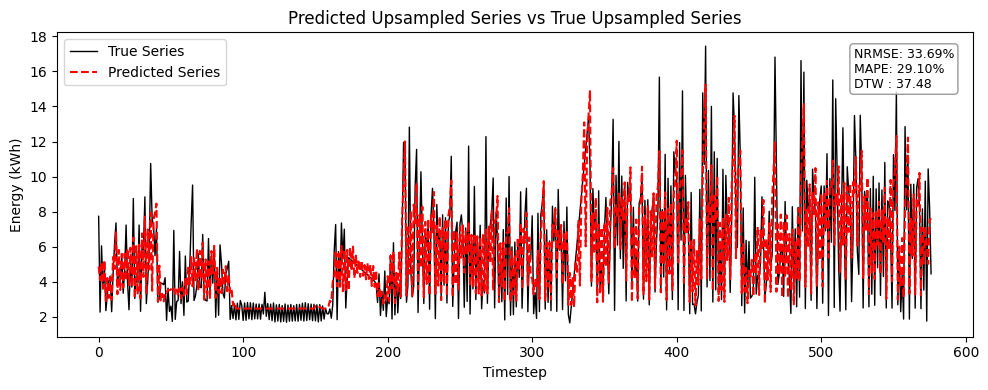

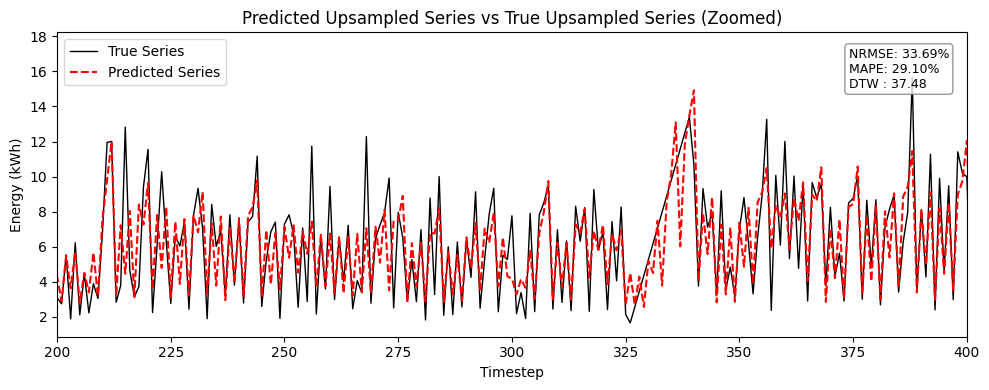

In [91]:
eval = model_evaluation(predicted_series_scaled, y_test, X_test, zoom_start=200, zoom_span=200)

# Hyperparameter Tuning

Hyperparameters:

Preprocessing:
* sequence_length
* stride
* num_seqs_to_add
* noise_level

Seq2Seq Models:
* hidden_size
* mapping_size
* num_layers
* dropout
* teacher_forcing_ratio

1D CNN Models:
* hidden_size
* kernel_sizes
* dropout

1D UNet
* hidden_size
* kernel_size

Training:
* learning_rate
* batch_size

In [92]:
def random_grid_search(param_grid, model_id, max_epochs, patience, num_trials):

    best_params = None
    best_rmse = float("inf")
    file_name = f"best_model_{model_id}.pt"

    # Creating random parameter combinations
    keys, values = zip(*param_grid.items())
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    combinations = random.sample(all_combinations, min(num_trials, len(all_combinations)))

    for i, combo in enumerate(combinations, 1):
        print(f"Trial {i}: {combo}")

        # Get parameters
        seq_length = combo["sequence_length"]
        num_seqs_to_add = combo["num_seqs_to_add"]
        noise_level = combo["noise_level"]
        stride = combo["stride"]
        hidden_size = combo["hidden_size"]
        mapping_size = combo["mapping_size"]
        kernel_sizes = combo["kernel_sizes"]
        num_layers = combo["num_layers"]
        dropout = combo["dropout"]
        lr = combo["lr"]
        teacher_forcing_ratio = combo["teacher_forcing_ratio"]
        batch_size = combo["batch_size"]

        # Split into overlapping sequences for more training data
        train_seqs = sliding_window(X_train_norm, sequence_length, stride)
        train_target_seqs = sliding_window(y_train_norm, sequence_length, stride)

        # Split into non-overlapping sequences
        val_seqs = split_into_sequences(X_val_norm, seq_length)
        val_target_seqs = split_into_sequences(y_val_norm, seq_length)
        test_seqs = split_into_sequences(X_test_norm, seq_length)
        test_target_seqs = split_into_sequences(y_test_norm, seq_length)

        # Additional Data Augmentation
        train_seqs = add_noise_to_sequences(train_seqs, num_seqs_to_add, noise_level)
        train_target_seqs = add_noise_to_sequences(train_target_seqs, num_seqs_to_add, noise_level)

        # Datasets and Dataloaders
        train_dataset = EnergyDataset(train_seqs, train_target_seqs)
        val_dataset = EnergyDataset(val_seqs, val_target_seqs)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Model Initialization
        match model_id:
            case 0:
                # ------ Seq2Seq Model ------ #
                input_size = 1
                output_size = 1
                # Initialization
                encoder = Encoder1(
                    input_size,
                    hidden_size,
                    mapping_size,
                    num_layers,
                    dropout=dropout
                )
                decoder = Decoder1(
                    output_size,
                    hidden_size,
                    mapping_size,
                    num_layers,
                    dropout=dropout
                )
                model = Seq2Seq1(encoder, decoder, device).to(device)

            case 1:
                # ------ Attention Seq2Seq Model ------ #
                input_size = 1
                output_size = 1
                # Initialization
                attention = Attention(hidden_size, hidden_size)
                encoder = AttentionEncoder(
                    input_size,
                    hidden_size,
                    mapping_size,
                    num_layers,
                    dropout=dropout
                )
                decoder = AttentionDecoder(
                    output_size,
                    hidden_size,
                    mapping_size,
                    num_layers,
                    attention=attention,
                    dropout=dropout
                )
                model = AttentionSeq2Seq(encoder, decoder, device).to(device)

            case 2:
                # ------ 1D CNN Model with Residual Connection ------ #
                # Model Hyperparameters
                input_size = 1
                output_size = 1

                # Initialization
                model = ResidualConv1d(input_size, output_size, hidden_size, kernel_sizes, dropout).to(device)

            case 3:
                # ------ Basic 1D CNN Model without Residual Connection ------ #
                # Model Hyperparameters
                input_size = 1
                output_size = 1

                # Initialization
                model = BasicConv1d(input_size, output_size, hidden_size, kernel_sizes, dropout).to(device)

            case 4:
                # ------ 1D Dilation CNN Model ------ #
                # Model Hyperparameters
                input_size = 1
                output_size = 1

                # Initialization
                model = DilationConv1d(input_size, output_size, hidden_size, kernel_sizes, dropout).to(device)

            case 5:
                # ------ 1D UNet ------ #
                # Model Hyperparameters
                input_size = 1
                output_size = 1

                # Initialization
                model = UNet1D(input_size, output_size, hidden_size, kernel_sizes).to(device)

        # Number of Parameters
        print(f"Model {model_id} has {count_parameters(model):,} trainable parameters.")

        # Initialize Weights
        model.apply(init_weights)

        # Train-Val Loop
        train_losses = []
        val_losses = []
        best_config_loss = float("inf")
        epochs_no_improv = 0
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        clip = 1
        match model_id:
            case 0 | 1:
                # For Seq2Seq LSTM Models
                for epoch in tqdm.tqdm(range(1, max_epochs + 1)):
                    train_loss = train_one_epoch(model,
                                                train_dataloader,
                                                optimizer,
                                                criterion,
                                                clip,
                                                teacher_forcing_ratio,
                                                device=device,
                                                train_losses=train_losses)

                    val_loss = val_one_epoch(model,
                                            val_dataloader,
                                            criterion,
                                            device=device,
                                            val_losses=val_losses)

                    if val_loss < best_config_loss:
                        best_config_loss = val_loss
                        epochs_no_improv = 0
                    else:
                        epochs_no_improv += 1

                    if epochs_no_improv >= patience:
                        break

            case 2 | 3 | 4 | 5:
                # For 1D CNN Models
                for epoch in tqdm.tqdm(range(1, max_epochs + 1)):
                    train_loss = train_one_epoch(model,
                                                train_dataloader,
                                                optimizer,
                                                criterion,
                                                clip,
                                                device=device,
                                                train_losses=train_losses)

                    val_loss = val_one_epoch(model,
                                            val_dataloader,
                                            criterion,
                                            device=device,
                                            val_losses=val_losses)

                    if val_loss < best_config_loss:
                        best_config_loss = val_loss
                        epochs_no_improv = 0
                    else:
                        epochs_no_improv += 1

                    if epochs_no_improv >= patience:
                        break

        # Plotting Train-Val Curves
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epoch + 1), train_losses, label='Train Loss', marker='o', markersize = 4)
        plt.plot(range(1, epoch + 1), val_losses, label='Validation Loss', marker='o', markersize = 4)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training vs Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        print(f"\nBest Validation Loss: {best_config_loss:.6f}")

        # Predict and calculate RMSE
        all_predictions = []
        for i in range(test_seqs.shape[0]):
            input_sequence = test_seqs[i]

            prediction = predict_sequence(model, input_sequence)
            all_predictions.append(prediction)

        # Convert list to numpy array with shape: (N, sequence_length)
        all_predictions = np.array(all_predictions).squeeze(-1)

        # Post-Processing
        _, predicted_series_scaled = post_process(all_predictions, X_test, scaler)

        # RMSE
        current_rmse = root_mean_squared_error(predicted_series_scaled, y_test)
        print(f"RMSE: {current_rmse:.4f}\n")

        # Save best combination
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_params = combo

            # Save the best model
            torch.save(model.state_dict(), file_name)

    print(f"\nBest Combination: {best_params}")
    print(f"Best RMSE: {best_rmse:.4f}")

    return best_params, best_rmse, test_seqs

Trial 1: {'sequence_length': 100, 'num_seqs_to_add': 0, 'noise_level': 0.05, 'stride': 1, 'hidden_size': 64, 'mapping_size': None, 'kernel_sizes': [7, 7, 7, 1], 'num_layers': None, 'dropout': 0.5, 'lr': 0.01, 'teacher_forcing_ratio': None, 'batch_size': 64}
Model 3 has 58,049 trainable parameters.


100%|██████████| 75/75 [00:19<00:00,  3.90it/s]


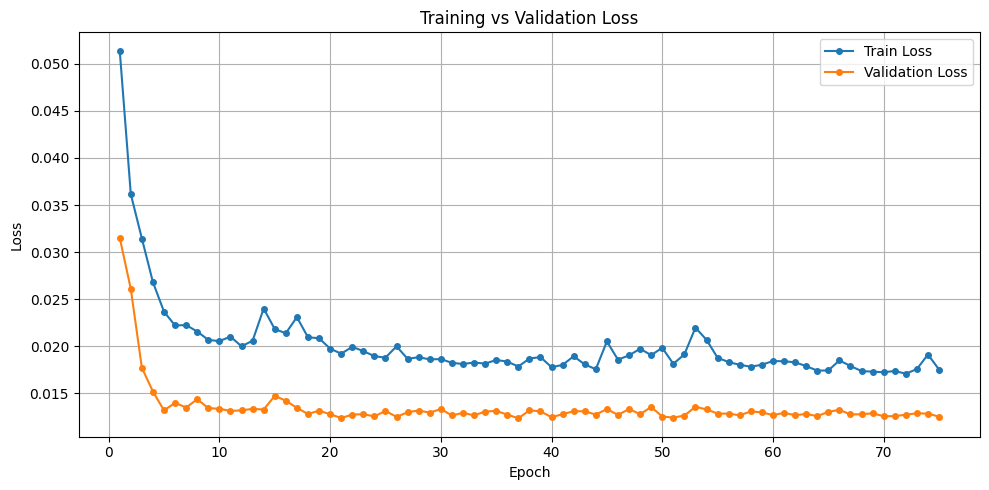


Best Validation Loss: 0.012343
RMSE: 1.8717


Best Combination: {'sequence_length': 100, 'num_seqs_to_add': 0, 'noise_level': 0.05, 'stride': 1, 'hidden_size': 64, 'mapping_size': None, 'kernel_sizes': [7, 7, 7, 1], 'num_layers': None, 'dropout': 0.5, 'lr': 0.01, 'teacher_forcing_ratio': None, 'batch_size': 64}
Best RMSE: 1.8717


In [93]:
# General grid for search
# param_grid_test = {
#     "sequence_length": [75, 100, 150, 200],
#     "num_seqs_to_add": [0, 100, 500],
#     "noise_level": [0.05],
#     "stride": [1],
#     "hidden_size": [64, 128, 512],
#     "mapping_size": [64, 128, 256, 512],
#     "kernel_sizes": [[7,7,7,1], [7,5,3,1]],
#     "num_layers": [2, 3, 4],
#     "dropout": [0, 0.05, 0.1, 0.25, 0.5],
#     "lr": [1e-2],
#     "teacher_forcing_ratio": [0.2, 0.3, 0.4, 0.5],
#     "batch_size": [64]
# }

match model_id:
    case 0:
        # Best Parameters Found (Model 0)
        param_grid = {
            "sequence_length": [10],
            "num_seqs_to_add": [0],
            "noise_level": [0.05],
            "stride": [10],
            "hidden_size": [512],
            "mapping_size": [128],
            "kernel_sizes": [None],
            "num_layers": [2],
            "dropout": [0.2],
            "lr": [5e-4],
            "teacher_forcing_ratio": [0.4],
            "batch_size": [32]
        }
    case 1:
        # Best Parameters Found (Model 1)
        param_grid = {
            "sequence_length": [10],
            "num_seqs_to_add": [0],
            "noise_level": [0.05],
            "stride": [10],
            "hidden_size": [512],
            "mapping_size": [128],
            "kernel_sizes": [None],
            "num_layers": [2],
            "dropout": [0.2],
            "lr": [5e-4],
            "teacher_forcing_ratio": [0.5],
            "batch_size": [32]
        }
    case 2 | 3:
        # Best Parameters Found (Model 2, 3)
        param_grid = {
            "sequence_length": [100],
            "num_seqs_to_add": [0],
            "noise_level": [0.05],
            "stride": [1],
            "hidden_size": [64],
            "mapping_size": [None],
            "kernel_sizes": [[7,7,7,1]],
            "num_layers": [None],
            "dropout": [0.5],
            "lr": [0.01],
            "teacher_forcing_ratio": [None],
            "batch_size": [64]
        }
    case 4:
        # Best Parameters Found (Model 4)
        param_grid = {
            "sequence_length": [150],
            "num_seqs_to_add": [0],
            "noise_level": [0.05],
            "stride": [1],
            "hidden_size": [64],
            "mapping_size": [None],
            "kernel_sizes": [[5,5,5,1]],
            "num_layers": [None],
            "dropout": [0.25],
            "lr": [5e-3],
            "teacher_forcing_ratio": [None],
            "batch_size": [64]
        }
    case 5:
        # Best Parameters Found (Model 5)
        param_grid = {
            "sequence_length": [100],
            "num_seqs_to_add": [0],
            "noise_level": [0.05],
            "stride": [1],
            "hidden_size": [64],
            "mapping_size": [None],
            "kernel_sizes": [3],
            "num_layers": [None],
            "dropout": [None],
            "lr": [5e-3],
            "teacher_forcing_ratio": [None],
            "batch_size": [64]
        }

max_epochs = 75   # Maximum number of epochs for the trial training
num_trials = 15    # Number of random combinations to try
patience = 40     # Patience for early stopping

best_params, best_rmse, test_seqs = random_grid_search(param_grid, model_id, max_epochs, patience, num_trials)


# Load & Evaluate Best Model

Initialization

In [94]:
match model_id:
    case 0:
        encoder = Encoder1(
            input_size,
            best_params["hidden_size"],
            best_params["mapping_size"],
            best_params["num_layers"],
            dropout=best_params["dropout"]
        )
        decoder = Decoder1(
            output_size,
            best_params["hidden_size"],
            best_params["mapping_size"],
            best_params["num_layers"],
            dropout=best_params["dropout"]
        )
        best_model = Seq2Seq1(encoder, decoder, device).to(device)

        # Load weights
        best_model.load_state_dict(torch.load("best_model_0.pt"))

    case 1:
        attention = Attention(best_params["hidden_size"], best_params["hidden_size"])
        encoder = AttentionEncoder(
            input_size,
            best_params["hidden_size"],
            best_params["mapping_size"],
            best_params["num_layers"],
            dropout=best_params["dropout"]
        )
        decoder = AttentionDecoder(
            output_size,
            best_params["hidden_size"],
            best_params["mapping_size"],
            best_params["num_layers"],
            attention=attention,
            dropout=best_params["dropout"]
        )
        best_model = AttentionSeq2Seq(encoder, decoder, device).to(device)

        # Load weights
        weights_path = "best_model_1.pt"
        best_model.load_state_dict(torch.load(weights_path))

    case 2:
        best_model = ResidualConv1d(input_size,
                                    output_size,
                                    best_params["hidden_size"],
                                    best_params["kernel_sizes"],
                                    best_params["dropout"]).to(device)

        # Load weights
        weights_path = "best_model_2.pt"
        best_model.load_state_dict(torch.load(weights_path))

    case 3:
        best_model = BasicConv1d(input_size,
                                    output_size,
                                    best_params["hidden_size"],
                                    best_params["kernel_sizes"],
                                    best_params["dropout"]).to(device)

        # Load weights
        weights_path = "best_model_3.pt"
        best_model.load_state_dict(torch.load(weights_path))

    case 4:
        best_model = DilationConv1d(input_size,
                                    output_size,
                                    best_params["hidden_size"],
                                    best_params["kernel_sizes"],
                                    best_params["dropout"]).to(device)

        # Load weights
        weights_path = "best_model_4.pt"
        best_model.load_state_dict(torch.load(weights_path))

    case 5:
        best_model = UNet1D(input_size,
                            output_size,
                            best_params["hidden_size"],
                            best_params["kernel_sizes"]).to(device)

        # Load weights
        weights_path = "best_model_5.pt"
        best_model.load_state_dict(torch.load(weights_path))

Prediction & Evaluation

Interpolation Method's Total MAE: 2.075
Interpolation Method's Total RMSE: 2.748
Interpolation Method's Total Normalized RMSE: 49.17%
Interpolation Method's Total MAPE: 48.07%
Interpolation Method's DTW Distance: 56.97

Model's Total MAE: 1.335
Model's Total RMSE: 1.872
Model's Total Normalized RMSE: 33.49%
Model's Total MAPE: 27.00%
Model's DTW Distance: 37.07



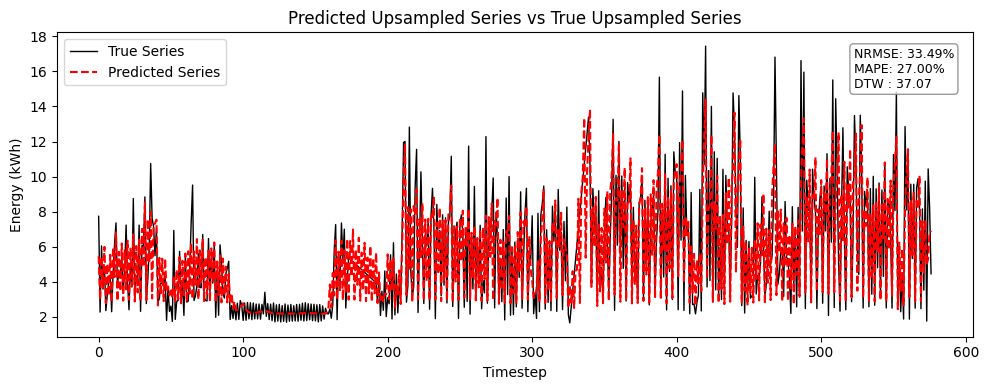

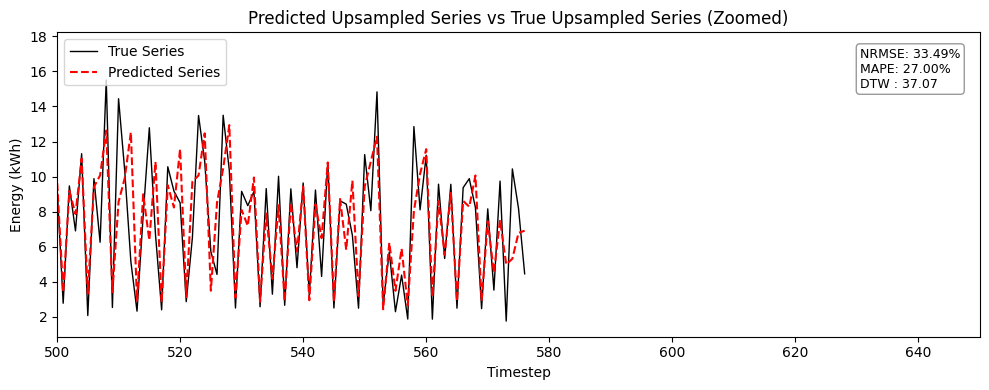

In [95]:
# Make Predictions
all_predictions = []

for i in range(test_seqs.shape[0]):
    input_sequence = test_seqs[i]

    prediction = predict_sequence(best_model, input_sequence)
    all_predictions.append(prediction)

# Convert list to numpy array with shape: (N, sequence_length)
all_predictions = np.array(all_predictions).squeeze(-1)

# Post-Processing
_, predicted_series_scaled = post_process(all_predictions, X_test, scaler)

# Evaluation
eval = model_evaluation(predicted_series_scaled, y_test, X_test, zoom_start=500, zoom_span=150)

# Evaluating Trained Model on Data with Different Temporal Resolutions

*Only for upsampling factor 2.

In [96]:
# Total Monthly Energy
total_monthly_energy = df['Energy_filled'].resample('ME').sum()

# Total Semi-Monthly Energy (x2)
total_semimonthly_energy = df['Energy_filled'].resample('SME').sum()

# Total Energy every 10 days (x3)
# total_10day_energy = df['Energy_filled'].resample('10d').sum()

# Total Energy every 8 days (x4)
# total_8day_energy = df['Energy_filled'].resample('8d').sum()

# Total Energy every 5 days (x6)
# total_5day_energy = df['Energy_filled'].resample('5d').sum()

Upsampling Factor: 2 



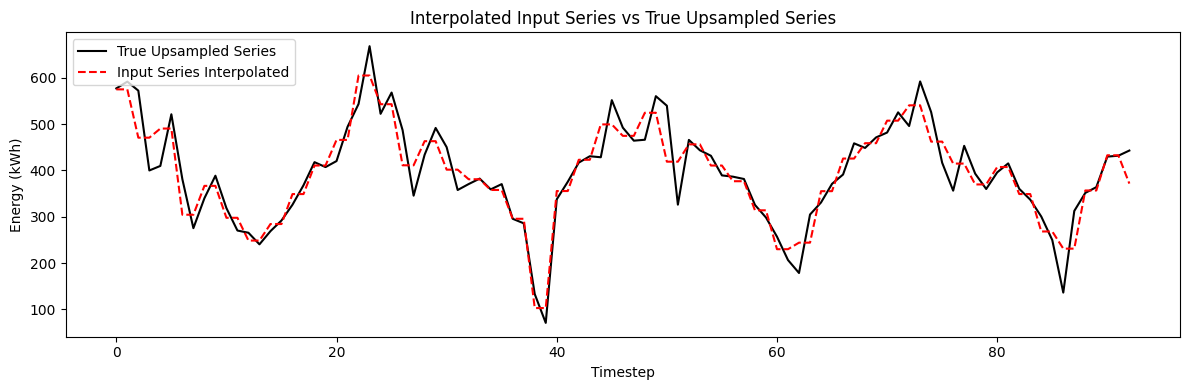


Input Series Shape after Interpolation: (93,)
Input Series Shape before Interpolation: (47,)
Input Sequence Array Shape: (1, 100)
True Sequence Shape: (93,)


In [97]:
# Picking which Series will be used for the testing
low_freq_series = total_monthly_energy            # Input series
high_freq_series = total_semimonthly_energy       # True upsampled series for evaluating predictions

# Upsampling Factor
upsampling_factor = round(len(high_freq_series) / len(low_freq_series))
print("Upsampling Factor:", upsampling_factor, "\n")

# Alignment so that low_freq_series and high_freq_series start from the same index
low_freq_series = low_freq_series.iloc[1:].values
high_freq_series = high_freq_series.iloc[1:-1].values

# Upsampling input series with interpolation
low_freq_interpolated = interpolate_list(low_freq_series, upsampling_factor, 'nearest')

# Dividing total energy by upsampling_factor
low_freq_interpolated = low_freq_interpolated/upsampling_factor

monthly_test_target = high_freq_series  # True Upsampled Series (y_test)
monthly_test_X = low_freq_interpolated  # Input Series (X_test)

# Normalize input series
scaler2 = MinMaxScaler(feature_range=(0, 1))
monthly_test_X_norm = scaler2.fit_transform(monthly_test_X.reshape(-1, 1)).reshape(-1)

# Split into non-overlapping sequences to feed into the model for prediction
monthly_test_seqs = split_into_sequences(monthly_test_X_norm, best_params["sequence_length"])

# Plot
plt.figure(figsize=(12, 4))
plt.plot(high_freq_series, label='True Upsampled Series', color='black')
plt.plot(low_freq_interpolated, label='Input Series Interpolated', color='red', linestyle='--')
plt.title('Interpolated Input Series vs True Upsampled Series')
plt.xlabel('Timestep')
plt.ylabel('Energy (kWh)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print("\nInput Series Shape after Interpolation:", monthly_test_X_norm.shape)
print("Input Series Shape before Interpolation:", low_freq_series.shape)
print("Input Sequence Array Shape:", monthly_test_seqs.shape)
print("True Sequence Shape:", monthly_test_target.shape)

Feeding Input Sequence to the Model and getting the Prediction

In [98]:
# List to store predictions
all_predictions = []

for i in range(monthly_test_seqs.shape[0]):
    input_sequence = monthly_test_seqs[i]

    prediction = predict_sequence(best_model, input_sequence)
    all_predictions.append(prediction)

# Convert list to numpy array with shape: (N, sequence_length)
all_predictions = np.array(all_predictions).squeeze(-1)

# Post-Processing prediction (combining predictions into one, inverting normalization, scaling)
predicted_series, predicted_series_scaled = post_process(all_predictions, monthly_test_X, scaler2)

print("Prediction Array Shape:", all_predictions.shape)
print("Predicted Series Shape:", predicted_series_scaled.shape)

Prediction Array Shape: (1, 100)
Predicted Series Shape: (93,)


Evaluation

Interpolation Method's Total MAE: 31.202
Interpolation Method's Total RMSE: 40.832
Interpolation Method's Total Normalized RMSE: 10.33%
Interpolation Method's Total MAPE: 8.99%
Interpolation Method's DTW Distance: 328.58

Model's Total MAE: 94.059
Model's Total RMSE: 113.560
Model's Total Normalized RMSE: 28.74%
Model's Total MAPE: 28.66%
Model's DTW Distance: 802.04



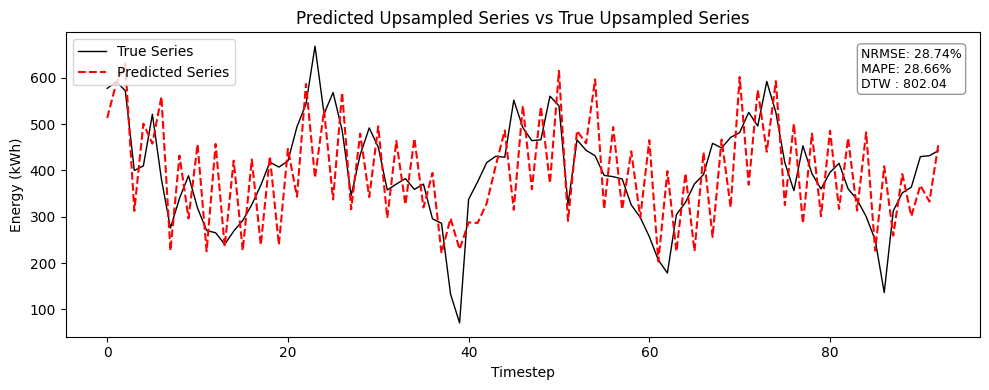

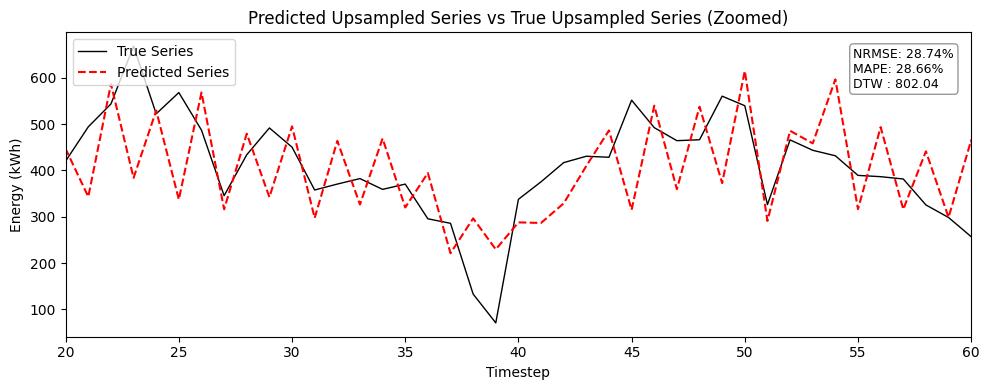

In [99]:
eval = model_evaluation(predicted_series_scaled, monthly_test_target, monthly_test_X, zoom_start=20, zoom_span=40)

Using the model on data with a lower resolution than the data it was trained on may produce noisy predictions.

# Evaluating Trained Model on Unseen Dataset

Length difference between high_freq_series and low_freq_series*upsampling_factor: 0 

Length difference between high_freq_series and low_freq_interpolated: 3 

Upsampling Factor: 4 

High frequency Time Series Length: 2192
Low frequency Time Series Length before Interpolation: 548
Low frequency Time Series Length after Interpolation: 2192 

High frequency Time Series starts at: 2018-07-02 00:00:00 and ends at 2019-12-31 18:00:00
Low frequency Time Series before Interpolation starts at: 2018-07-02 00:00:00 and ends at 2019-12-31 00:00:00
Low frequency Time Series after Interpolation starts at: 2018-07-02 00:00:00 and ends at 2019-12-31 18:00:00 

Total Energy in High frequency Time Series: 1394.51 MWh
Total Energy in Low frequency Time Series before Interpolation: 1394.51 MWh
Total Energy in Low frequency Time Series after Interpolation: 1394.10 MWh


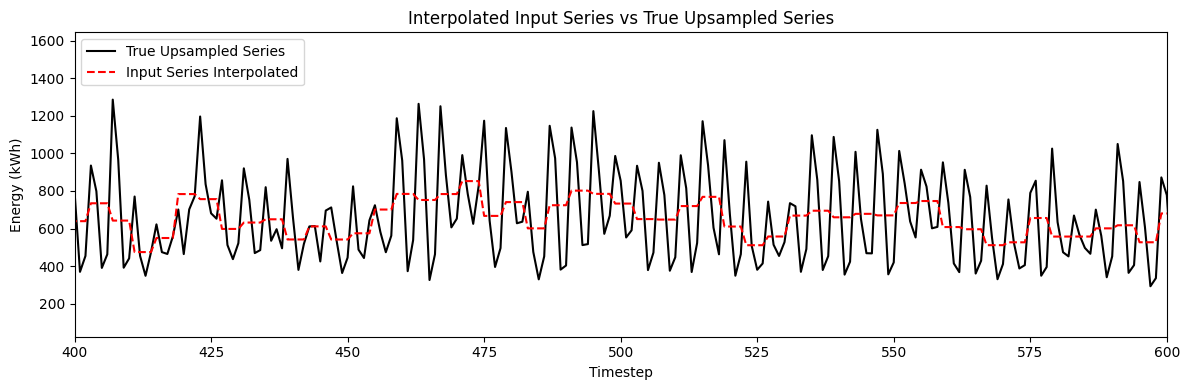


Input Series Shape after Interpolation: (2192,)
Input Series Shape before Interpolation: (548,)
Input Sequence Array Shape: (22, 100)
True Sequence Shape: (2192,)


In [100]:
# Sample Unseen Dataset
floor1_daily = floor1_df['total_consumption(kWh)'].resample('D').sum()
floor1_12h = floor1_df['total_consumption(kWh)'].resample('12h').sum()    # x2
# floor1_8h = floor1_df['total_consumption(kWh)'].resample('8h').sum()      # x3
floor1_6h = floor1_df['total_consumption(kWh)'].resample('6h').sum()      # x4
floor1_3h = floor1_df['total_consumption(kWh)'].resample('3h').sum()      # x8

# Picking which Series will be used for the testing
low_freq_series = floor1_daily          # Input series
match up_factor:
    case 2:
        high_freq_series = floor1_12h   # True upsampled series for evaluating predictions
    case 4:
        high_freq_series = floor1_6h    # True upsampled series for evaluating predictions
    case 8:
        high_freq_series = floor1_3h    # True upsampled series for evaluating predictions

# Upsampling Factor
upsampling_factor = round(len(high_freq_series) / len(low_freq_series))

# Calculating length mismatch
length_diff1 = upsampling_factor*len(low_freq_series) - len(high_freq_series)
print("Length difference between high_freq_series and low_freq_series*upsampling_factor:", length_diff1, "\n")

# Alignment so that low_freq_series and high_freq_series start from the same index
low_freq_series = low_freq_series.iloc[1:]
high_freq_series = high_freq_series.iloc[upsampling_factor - length_diff1:]

# Upsample Low Freq Series with Interpolation
frequency = f"{1440 // upsampling_factor}min"     # 24h = 1440min
low_freq_interpolated = low_freq_series.resample(frequency).interpolate(method='nearest')
# print(frequency)

# Calculating length mismatch
length_diff2 = len(high_freq_series) - len(low_freq_interpolated)
print("Length difference between high_freq_series and low_freq_interpolated:", length_diff2, "\n")

# Repeat last value until the interpolated series has the same length as the high frequency series
for _ in range(length_diff2):
    low_freq_interpolated.loc[low_freq_interpolated.index[-1] + pd.Timedelta(frequency)] = low_freq_interpolated.iloc[-1]

# Dividing total energy by upsampling_factor
low_freq_interpolated = low_freq_interpolated/upsampling_factor

print("Upsampling Factor:", upsampling_factor, "\n")
print("High frequency Time Series Length:", len(high_freq_series))
print("Low frequency Time Series Length before Interpolation:", len(low_freq_series))
print("Low frequency Time Series Length after Interpolation:", len(low_freq_interpolated), "\n")

print("High frequency Time Series starts at:", high_freq_series.index[0], "and ends at", high_freq_series.index[-1])
print("Low frequency Time Series before Interpolation starts at:", low_freq_series.index[0], "and ends at", low_freq_series.index[-1])
print("Low frequency Time Series after Interpolation starts at:", low_freq_interpolated.index[0], "and ends at", low_freq_interpolated.index[-1], "\n")

print(f"Total Energy in High frequency Time Series: {high_freq_series.sum()/1000:.2f} MWh")
print(f"Total Energy in Low frequency Time Series before Interpolation: {low_freq_series.sum()/1000:.2f} MWh")
print(f"Total Energy in Low frequency Time Series after Interpolation: {low_freq_interpolated.sum()/1000:.2f} MWh")

test_target = high_freq_series.values  # True Upsampled Series (y_test)
test_X = low_freq_interpolated.values  # Input Series (X_test)

# Normalize input series
scaler2 = MinMaxScaler(feature_range=(0, 1))
test_X_norm = scaler2.fit_transform(test_X.reshape(-1, 1)).reshape(-1)

# Split into non-overlapping sequences to feed into the model for prediction
unseen_test_seqs = split_into_sequences(test_X_norm, best_params["sequence_length"])

# Plot
plt.figure(figsize=(12, 4))
plt.plot(high_freq_series.values, label='True Upsampled Series', color='black')
plt.plot(low_freq_interpolated.values, label='Input Series Interpolated', color='red', linestyle='--')
plt.title('Interpolated Input Series vs True Upsampled Series')
plt.xlabel('Timestep')
plt.ylabel('Energy (kWh)')
plt.legend(loc='upper left')
plt.xlim(400, 600)
plt.tight_layout()
plt.show()

print("\nInput Series Shape after Interpolation:", test_X_norm.shape)
print("Input Series Shape before Interpolation:", low_freq_series.shape)
print("Input Sequence Array Shape:", unseen_test_seqs.shape)
print("True Sequence Shape:", test_target.shape)

Feeding Input Sequence to the Model and getting the Prediction

In [101]:
# List to store predictions
all_predictions = []

for i in range(unseen_test_seqs.shape[0]):
    input_sequence = unseen_test_seqs[i]

    prediction = predict_sequence(best_model, input_sequence)
    all_predictions.append(prediction)

# Convert list to numpy array with shape: (N, sequence_length)
all_predictions = np.array(all_predictions).squeeze(-1)

# Post-Processing prediction (combining predictions into one, inverting normalization, scaling)
predicted_series, predicted_series_scaled = post_process(all_predictions, test_X, scaler2)

print("Prediction Array Shape:", all_predictions.shape)
print("Predicted Series Shape:", predicted_series_scaled.shape)

Prediction Array Shape: (22, 100)
Predicted Series Shape: (2192,)


Evaluation

Interpolation Method's Total MAE: 185.382
Interpolation Method's Total RMSE: 219.469
Interpolation Method's Total Normalized RMSE: 34.50%
Interpolation Method's Total MAPE: 33.69%
Interpolation Method's DTW Distance: 9576.58

Model's Total MAE: 206.421
Model's Total RMSE: 239.750
Model's Total Normalized RMSE: 37.69%
Model's Total MAPE: 39.28%
Model's DTW Distance: 7076.24



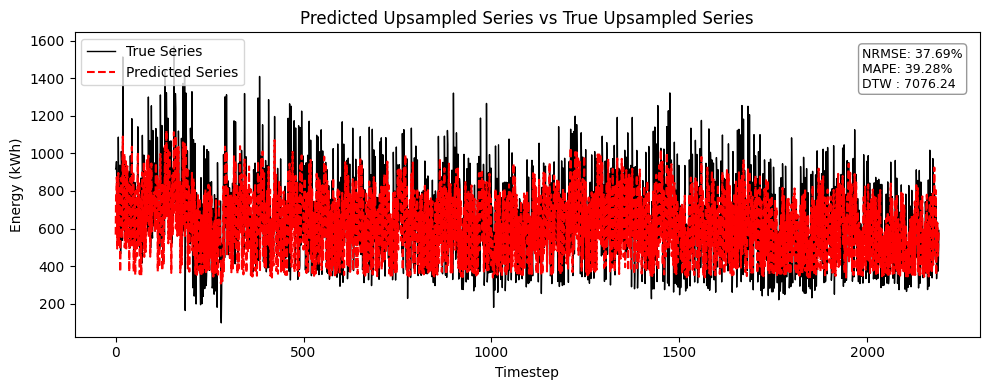

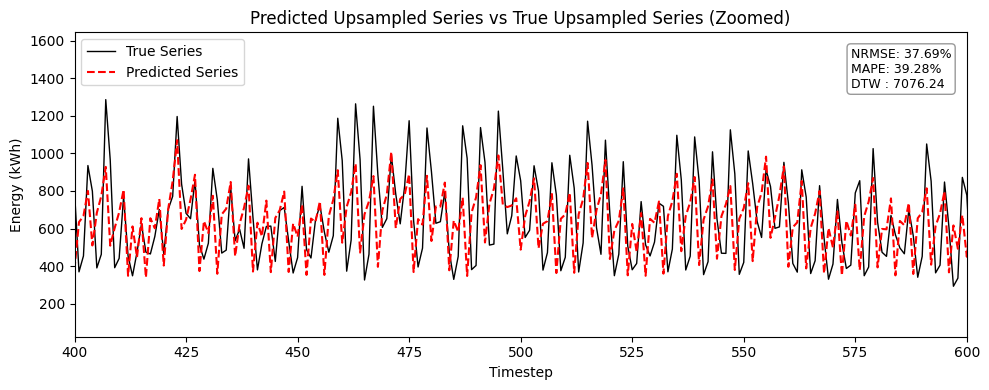

In [102]:
eval = model_evaluation(predicted_series_scaled, test_target, test_X, zoom_start=400, zoom_span=200)